<a href="https://colab.research.google.com/github/hoangdungnguyen/XVA-stage/blob/master/Deep_Randomized_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np
import time
import sys, gc
import seaborn as sns
import random

from tqdm.notebook import tqdm
import math
import scipy as si
from scipy.stats import norm
import pandas as pd
import tensorflow as tf
import tensorflow.compat.v1 as tf1
from sklearn.preprocessing import PolynomialFeatures


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import torch 
from torch import matmul
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torch.nn.functional as F
import torch.distributions as tdist
print('GPU available: ',torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


GPU available:  True


# 0 Some tool functions

In [0]:
def KMeans(x, K=10, Niter=20, verbose=False):
    x = x.to(device)
    N, D = x.shape  # Number of samples, dimension of the ambient space

    # K-means loop:
    # - x  is the point cloud,
    # - cl is the vector of class labels
    # - c  is the cloud of cluster centroids
    start = time.time()
    c = x[np.random.permutation(N)[:K], :].clone()  # Simplistic random initialization
    x_i = x[:, None, :]  # (Npoints, 1, D)

    for i in range(Niter):

        c_j = c[None, :, :]  # (1, Nclusters, D)
        D_ij = ((x_i - c_j) ** 2).sum(-1)  # (Npoints, Nclusters) symbolic matrix of squared distances
        cl = D_ij.argmin(dim=1).long().view(-1)  # Points -> Nearest cluster

        Ncl = torch.bincount(cl).type(torch.float)  # Class weights
        for d in range(D):  # Compute the cluster centroids with torch.bincount:
            c[:, d] = torch.bincount(cl, weights=x[:, d]) / Ncl

    end = time.time()

    if verbose:
        print("K-means example with {:,} points in dimension {:,}, K = {:,}:".format(N, D, K))
        print('Timing for {} iterations: {:.5f}s = {} x {:.5f}s\n'.format(
                Niter, end - start, Niter, (end-start) / Niter))

    return cl, c

# 1 Data simulator

In [0]:
class call_pricing_generator:

    def __init__(self, dim_X = 5, T = 1.5, r = 0.025, random_state = None) :
        self.dim_X = dim_X
        self.K = np.random.RandomState(random_state).uniform(80, 120, dim_X)
        self.T = T
        self.r = r
        self.sigma = np.random.RandomState(random_state).uniform(0.1,0.5, dim_X)
        self.omega = np.random.RandomState(random_state).uniform(0.,1., dim_X)
  
    def print_para(self):
        return {'dim_X': self.dim_X, 'K': self.K, 'T': self.T, 'r': self.r, 
                'sigma': self.sigma, 'omega': self.omega}

    def simulate(self, N_sim = 10000, random_state = None):
        payoff = np.zeros([N_sim, self.dim_X])
        price = np.zeros([N_sim, self.dim_X])
        S0 = np.zeros([N_sim, self.dim_X])
        for i in range(self.dim_X):
            S0[:,i] = np.random.RandomState(random_state).uniform(10+i*5, 180+i*5, N_sim)
            ST = S0[:,i]*np.exp((self.r-0.5*self.sigma[i]**2)*self.T+self.sigma[i]*np.sqrt(self.T)*np.random.normal(size=N_sim))
            payoff[:,i] = np.exp(-self.r*self.T)*np.maximum(ST-self.K[i], 0)
            d1 = (np.log(S0[:,i]/self.K[i])+(self.r+0.5*self.sigma[i]**2)*self.T)/(self.sigma[i]*np.sqrt(self.T))
            d2 = d1 - self.sigma[i]*np.sqrt(self.T)
            price[:,i] = S0[:,i]*norm.cdf(d1)-np.exp(-self.r*self.T)*self.K[i]*norm.cdf(d2)
            
        payoff = np.sum(payoff*self.omega, axis = 1)
        price = np.sum(price*self.omega, axis = 1)
        return (torch.from_numpy(S0.reshape(-1,self.dim_X)).type(torch.FloatTensor),
                torch.from_numpy(payoff.reshape(-1,1)).type(torch.FloatTensor), 
                torch.from_numpy(price.reshape(-1,1)).type(torch.FloatTensor))

In [0]:
class var_es_generator:

    def __init__(self, X_dim = 20, eps = 0.025, lambda_rs = 10, mu_rs = 20):
        self.X_dim = X_dim
        self.eps = eps
        self.lambda_rs = lambda_rs
        self.mu_rs = mu_rs
        
    
    def mean_X(self):
        return np.zeros(self.X_dim)
    
    def var_X(self):
        return np.identity(self.X_dim)

    def cond_mean_std_Y(self, X, weight_vector): 
        poly = PolynomialFeatures(2)
        return np.sum(poly.fit_transform(X) * weight_vector, axis = 1)
    
    def simulate(self, nb_simulation = 10000, lambda_0 = 10., mu_0 = 3.) :
        X = np.random.multivariate_normal(self.mean_X(), self.var_X(), nb_simulation)
        #lambda vector : P1(x) = lambda_0 + sum lambda_i*xi + sum lambda_ij*xi*xj
        self.lambda_vector = np.append(lambda_0, np.random.RandomState(self.lambda_rs).normal(0,1, int(self.X_dim + self.X_dim*(self.X_dim+1)/2) ))

        #mu vector : P2(x) = mu_0 + sum mu_i*xi + sum mu_ij*xi*xj
        self.mu_vector = np.append(mu_0, np.random.RandomState(self.mu_rs).normal(0,1, int(self.X_dim + self.X_dim*(self.X_dim+1)/2) ))

        mean_Y = self.cond_mean_std_Y(X, self.lambda_vector)
        std_Y = self.cond_mean_std_Y(X, self.mu_vector)
        std_Y = np.sqrt(std_Y**2)
        
        Y = np.random.normal(mean_Y, std_Y)

        true_VaR = mean_Y - std_Y*norm.ppf(self.eps)
        true_ES = mean_Y + 1/self.eps * std_Y * norm.pdf(norm.ppf(self.eps)) 

        return (torch.from_numpy(X.reshape(nb_simulation, self.X_dim)).type(torch.FloatTensor), 
                torch.from_numpy(Y.reshape(-1,1)).type(torch.FloatTensor), 
                torch.from_numpy(true_VaR.reshape(-1,1)).type(torch.FloatTensor), 
                torch.from_numpy(true_ES.reshape(-1,1)).type(torch.FloatTensor),
                mean_Y,
                std_Y)


In [0]:
test = var_es_generator(X_dim = 5)
X_train, Y_train, true_VaR, true_ES, mean_Y,_ = test.simulate(10000, lambda_0= 20, mu_0 = 10)

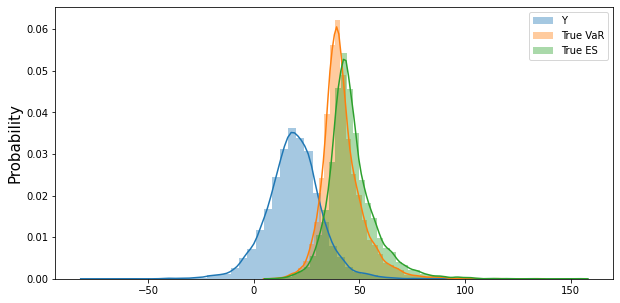

In [7]:
plt.figure(figsize=(10,5))
sns.distplot(Y_train.data, label='Y')
sns.distplot(true_VaR.data, label='True VaR')
sns.distplot(true_ES.data, label='True ES')
plt.title("", fontsize=12)
plt.xlabel("")
plt.ylabel("Probability", fontsize=15)
plt.legend()

#2 Randomized layers

In [0]:
class Randomprojection:

    def __init__(self, Layers = [10, 100], random_state = None, activation = 'sigmoid'):

        self.W, self.b =[], []
        if random_state == None:
            for input_size, output_size in zip(Layers, Layers[1:]):
                self.W.append(tdist.normal.Normal(0., 1.).sample((input_size, output_size)))
                self.b.append(tdist.normal.Normal(0., 1.).sample((output_size,)))
        else:
            for i,input_size, output_size in zip(range(len(Layers)-1),Layers, Layers[1:]):
                torch.manual_seed(random_state+i)
                self.W.append(tdist.normal.Normal(0., 1.).sample((input_size, output_size)))
                torch.manual_seed(2*random_state+i)
                self.W.append(tdist.normal.Normal(0., 1.).sample((output_size,)))

        if activation.capitalize() == 'Sigmoid' :
            self.activation = torch.sigmoid
        elif activation.capitalize() == 'Relu':
            self.activation = F.relu
        elif activation.capitalize() == 'Tanh':
            self.activation = torch.tanh
        elif activation.capitalize() == 'Log_softmax':
            self.activation = F.log_softmax
        elif activation.capitalize() == 'Leakyrelu':
            self.activation = F.leaky_relu

    def fit_transform(self, X):
        X = X.to(device)
        for W,b in zip(self.W, self.b):
            X = self.activation(torch.matmul(X, W.to(device)) + b.to(device))
        return X

In [0]:
class Autoencoder(nn.Module):

    def __init__(self, Layers = [1,20,40], activation = 'relu'):
        super(Autoencoder, self).__init__()
        self.hidden = nn.ModuleList()
        # Example: Encoder 1 - 20 - 40 and Decoder 40 - 20 - 1
        Layers = Layers + Layers[::-1]
        self.hidden = nn.ModuleList()
        for input_size, output_size in zip(Layers, Layers[1:]):
            self.hidden.append(nn.Linear(input_size, output_size))

        if activation.capitalize() == 'Sigmoid' :
            self.activation = torch.sigmoid
        elif activation.capitalize() == 'Relu':
            self.activation = F.relu
        elif activation.capitalize() == 'Tanh':
            self.activation = F.tanh
        elif activation.capitalize() == 'Log_softmax':
            self.activation = F.log_softmax
        elif activation.capitalize() == 'Leakyrelu':
            self.activation = F.leaky_relu

    def forward(self, x):
        x = x.to(device)
        L = len(self.hidden)
        for (l, linear_transform) in zip(range(L), self.hidden):
            if l < L - 1:
                x = self.activation(linear_transform(x))
            else:
                x = linear_transform(x)
        return x

    def forward_central_layer(self, x):
        x = x.to(device)
        L = int(len(self.hidden) / 2)
        for (l, linear_transform) in zip(range(L), self.hidden):
            if l < L - 1:
                x = self.activation(linear_transform(x))
            else:
                x = linear_transform(x)
        return x

In [0]:
class RBFlayer:
    """RBFlayer.
    Parameters
    ----------
    function: 
        'Gaussian', 'Multiquadric', 'Inverse quadratic' or 'Thin plate spline'.
    """

    def __init__(self, output_layer = 100, e = 1/2, function = 'gaussian'):
        self.K = output_layer
        if function.capitalize() == 'Gaussian' :
            self.activation = lambda x: torch.exp(-e*x)
        elif function.capitalize() == 'Multiquadric':
            self.activation = lambda x: torch.sqrt(1+e*x)
        elif function.capitalize() == 'Inverse quadratic':
            self.activation = lambda x: 1/(1+e*x)
        elif function.capitalize() == 'Thin plate spline':
            self.activation = lambda x: (x**2*torch.log(torch.clamp(x, min=1e-40) )).type(torch.DoubleTensor)


    def fit(self, X):
        _, self.centroids = KMeans(X, self.K, 10)
          
    def transform(self, X):
        self.centroids = self.centroids.to(device)
        dist= torch.empty((X.shape[0],self.K), dtype= torch.float)
        for j in range(self.K):
            dist[:,j] = torch.norm(X - self.centroids[j], dim = 1)
        return self.activation(dist**2)


#3 Readout layers

In [0]:
from sklearn.linear_model import LinearRegression

class LR_readout:
    
    def __init__(self, intercept = True, normalize=False):
        self.lin_reg = LinearRegression(fit_intercept=intercept, normalize=normalize, n_jobs=-1)

    def fit(self, X, y):
        self.lin_reg.fit(X.cpu(),y.cpu())
        self.coef = torch.tensor(self.lin_reg.coef_.T)
    def predict(self, X) :
        
        return torch.from_numpy(self.lin_reg.predict(X.cpu())).type(torch.FloatTensor).to(device)

    def l2_loss(self,X, y):
        y = y.to(device)
        return torch.mean((self.predict(X) - y)**2)

In [0]:
class NN_nlayers(nn.Module):

    def __init__(self, Layers, activation = 'relu'):
        super(NN_nlayers, self).__init__()
        self.hidden = nn.ModuleList()
        for input_size, output_size in zip(Layers, Layers[1:]):
            self.hidden.append(nn.Linear(input_size, output_size))

        if activation.capitalize() == 'Sigmoid' :
            self.activation = torch.sigmoid
        elif activation.capitalize() == 'Relu':
            self.activation = F.relu
        elif activation.capitalize() == 'Tanh':
            self.activation = F.tanh
        elif activation.capitalize() == 'Log_softmax':
            self.activation = F.log_softmax
        elif activation.capitalize() == 'Leakyrelu':
            self.activation = F.leaky_relu

    def forward(self, x):
        x = x.to(device)
        L = len(self.hidden)
        for (l, linear_transform) in zip(range(L), self.hidden):
            if l < L - 1:
                x = self.activation(linear_transform(x))
            else:
                x = linear_transform(x)
        return x

In [0]:
def train_quad_loss(model, X_train, y_train, eps = 1e-8, epochs=300, verbose = None):

    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    i = 0
    err = np.inf
    while (err >= eps) and (i < epochs):
        optimizer.zero_grad()
        pred = model.forward(X_train)
        loss = torch.mean((pred - y_train)**2)
        loss.backward()
        optimizer.step()
        err = loss.data.item()
        if verbose != None : 
            if i % verbose == 0:
                print('[iter {}] err = {}'.format(i, round(err, 3)))
        i += 1

## Optimal gradient descent learning rate for a quadratic loss function

Considering a quadratic loss for an input matrix ${X}$ (can include a one column vector relating the biais) and an output vector $y$
$$\mathcal{L}(A,b) = \mathbb{E} \left[ || {X}\underbrace{A}_{weight} + \underbrace{b}_{bias} - y ||_2^2  \right] \simeq \frac{1}{n} \left( {X}A + b - y \right)^T \left( {X}A + b - y \right)$$

The goal is to minimize the loss $\mathcal{L}$. Since 1/n is a constant, we can omit it:

$$\mathcal{L}(A,b) = A^T(X^TX)A + b^Tb + y^Ty + 2b^TXA - 2y^TXA - 2y^Tb$$

Suppose a positive real learning rate $\lambda$. The gradient descent with constant $\lambda$ is an iterative algorithm that aims to find a local minimum for $\mathcal{L}$. The updates:
$$A^{k+1} = A^{k} - \lambda \underbrace{\partial_A \mathcal{L}(A^{k}, b^{k})}_{\partial_A\mathcal{L}^{k}}$$
$$b^{k+1} = b^{k} - \lambda \underbrace{\partial_b \mathcal{L}(A^{k}, b^{k}}_{\partial_b\mathcal{L}^{k}})$$

In the case of stochastic learning rate, we rewrite the updates at step $k$ with $\lambda^k$ . The optimal learning rate could be:
$$\lambda^{k} = \arg \min \mathcal{L}(A^{k+1},b^{k+1})$$

Finally, we have:

$$\lambda^k = \frac{\left[X\partial_A\mathcal{L}^k+ \partial_b\mathcal{L}^k \right]^T\left[XA^k+b^k-y\right]}{[X\partial_A \mathcal{L}^k + \partial_b \mathcal{L}^k]^T[X\partial_A \mathcal{L}^k + \partial_b \mathcal{L}^k]}$$

In [0]:
def train_quad_loss_optimal(model, X_train, y_train, eps = 1e-8, epochs=5, verbose = None):
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
    A,b = model.parameters()
    i = 0
    err, best_err = np.inf, np.inf
    while (err >= eps) and (i < epochs):
        optimizer.zero_grad()
        pred = model.forward(X_train)
        loss = torch.mean((pred - y_train)**2)
        err = loss.data.item()
        if err < best_err:
            best_err = err
            torch.save(model.state_dict(), 'best')
        loss.backward()
        coef = torch.matmul(X_train, A.grad.T)+ b.grad
        lr = torch.matmul(coef.T, torch.matmul(X_train, A.data.T)+ b.data - y_train)/ torch.matmul(coef.T,coef)
        for param_group in optimizer.param_groups:
            param_group['lr'] = float(lr)
        
        
        optimizer.step()
        if verbose != None : 
            if i % verbose == 0:
                print('[iter {}] err = {} | learning rate = {}'.format(i, round(err, 3), round(float(lr),4)))
        i += 1
    model.load_state_dict(torch.load('best'))
    model.eval()
    

# 4 Pricing (conditional $\mathbb{E}$) problem

In [0]:
dim_X = 10
Pricing_Generator = call_pricing_generator(dim_X = dim_X)

S0_train, payoff_train, price_BS_train = Pricing_Generator.simulate(N_sim = 50000)
S0_test, payoff_test, price_BS_test = Pricing_Generator.simulate(N_sim = 50000)

X_train = (S0_train - S0_train.mean(axis = 0))/S0_train.std(axis = 0)
X_test = (S0_test - S0_train.mean(axis = 0))/S0_train.std(axis = 0)

X_train = X_train.to(device)
X_test = X_test.to(device)
payoff_train = payoff_train.to(device)
price_BS_train = price_BS_train.to(device)
payoff_test = payoff_test.to(device)
price_BS_test = price_BS_test.to(device)

y_train = payoff_train/payoff_train.std()

In [16]:
Pricing_Generator.print_para()

{'K': array([ 97.33381026, 102.17942399, 112.57485089, 115.3890944 ,
         81.62395701,  83.50095385, 106.88851659, 117.06090767,
         96.41660695,  92.17157409]),
 'T': 1.5,
 'dim_X': 10,
 'omega': array([0.54813087, 0.01010184, 0.74776006, 0.08429907, 0.94561916,
        0.45857757, 0.04857053, 0.24616042, 0.54757423, 0.69003406]),
 'r': 0.025,
 'sigma': array([0.25189535, 0.47259624, 0.17820859, 0.48012452, 0.37917374,
        0.30618639, 0.20212661, 0.49955206, 0.47657253, 0.41702732])}

In [17]:
print('\n Adam optimizer: ')
GD_test = NN_nlayers(Layers=[dim_X,1], activation = 'relu').to(device)
train_quad_loss(GD_test, X_train = X_train, y_train = y_train, verbose = 1, epochs = 50)

print('\n SGD optimizer with optimal learning rate: ')
GD_test = NN_nlayers(Layers=[dim_X,1], activation = 'relu').to(device)
train_quad_loss_optimal(GD_test, X_train = X_train, y_train = y_train, verbose = 1, epochs = 50)

p1=time.time()
print('\n Inverse matrix: ')
print(X_train.shape)
LRsolution_readout = LR_readout()
LRsolution_readout.fit(X_train, y_train)
print(LRsolution_readout.l2_loss(X_train, y_train))
print('Computation: ',time.time()-p1)


 Adam optimizer: 
[iter 0] err = 4.739
[iter 1] err = 4.088
[iter 2] err = 3.602
[iter 3] err = 3.227
[iter 4] err = 2.911
[iter 5] err = 2.628
[iter 6] err = 2.373
[iter 7] err = 2.145
[iter 8] err = 1.94
[iter 9] err = 1.753
[iter 10] err = 1.58
[iter 11] err = 1.422
[iter 12] err = 1.283
[iter 13] err = 1.163
[iter 14] err = 1.06
[iter 15] err = 0.973
[iter 16] err = 0.902
[iter 17] err = 0.847
[iter 18] err = 0.805
[iter 19] err = 0.777
[iter 20] err = 0.761
[iter 21] err = 0.753
[iter 22] err = 0.753
[iter 23] err = 0.758
[iter 24] err = 0.764
[iter 25] err = 0.771
[iter 26] err = 0.778
[iter 27] err = 0.786
[iter 28] err = 0.794
[iter 29] err = 0.801
[iter 30] err = 0.807
[iter 31] err = 0.811
[iter 32] err = 0.813
[iter 33] err = 0.813
[iter 34] err = 0.811
[iter 35] err = 0.809
[iter 36] err = 0.806
[iter 37] err = 0.802
[iter 38] err = 0.797
[iter 39] err = 0.79
[iter 40] err = 0.783
[iter 41] err = 0.775
[iter 42] err = 0.767
[iter 43] err = 0.76
[iter 44] err = 0.755
[iter 

### 2 hidden layers network without randomized layers

In [18]:
RMSE_NN_2layers = []
NRMSE_NN_2layers = []
p1 = time.time()

for i in tqdm(range(10)):
    NN_pricing = NN_nlayers(Layers=[dim_X,50,50,1], activation = 'Leakyrelu').to(device)
    train_quad_loss(NN_pricing, X_train = X_train, y_train = y_train, verbose = None, epochs = 300)

    predict_train = payoff_train.std()*NN_pricing(X_train)
    predict_test = payoff_train.std()*NN_pricing(X_test)

    RMSE_NN_2layers.append([torch.sqrt(torch.mean((predict_train - price_BS_train)**2)).data,
                            torch.sqrt(torch.mean((predict_test - price_BS_test)**2)).data])
    NRMSE_NN_2layers.append([torch.sqrt(torch.mean((predict_train - price_BS_train)**2)).data/ price_BS_train.std(),
                            torch.sqrt(torch.mean((predict_test - price_BS_test)**2)).data/ price_BS_test.std()])
print('Computation 10 times: ', time.time()-p1)


Computation 10 times:  5.005669355392456


### 4 hidden layers network without randomized layers

In [19]:
RMSE_NN_4layers = []
NRMSE_NN_4layers = []
p1 = time.time()

for i in tqdm(range(10)):
    NN_pricing = NN_nlayers(Layers=[dim_X,50,50,50,50,1], activation = 'Leakyrelu').to(device)
    train_quad_loss(NN_pricing, X_train = X_train, y_train = y_train, verbose = None, epochs = 300)

    predict_train = payoff_train.std()*NN_pricing(X_train)
    predict_test = payoff_train.std()*NN_pricing(X_test)

    RMSE_NN_4layers.append([torch.sqrt(torch.mean((predict_train - price_BS_train)**2)).data,
                            torch.sqrt(torch.mean((predict_test - price_BS_test)**2)).data])
    NRMSE_NN_4layers.append([torch.sqrt(torch.mean((predict_train - price_BS_train)**2)).data/ price_BS_train.std(),
                            torch.sqrt(torch.mean((predict_test - price_BS_test)**2)).data/ price_BS_test.std()])
print('Computation 10 times: ', time.time()-p1)


Computation 10 times:  9.27323865890503


### Random projection as randomized layer and Inverse matrix solution

In [20]:
RMSE_RP_LRsolution = []
NRMSE_RP_LRsolution = []
p1 = time.time()

for i in tqdm(range(10)):
    RP_sigmoid_1 = Randomprojection(Layers=[dim_X,200], random_state= None, activation= 'Leakyrelu')
    LRsolution_readout = LR_readout()
    LRsolution_readout.fit(RP_sigmoid_1.fit_transform(X_train), y_train)
    predict_train = payoff_train.std()*LRsolution_readout.predict(RP_sigmoid_1.fit_transform(X_train))
    predict_test = payoff_train.std()*LRsolution_readout.predict(RP_sigmoid_1.fit_transform(X_test))
    RMSE_RP_LRsolution.append([torch.sqrt(torch.mean((predict_train - price_BS_train)**2)),
                               torch.sqrt(torch.mean((predict_test - price_BS_test)**2))])
    NRMSE_RP_LRsolution.append([torch.sqrt(torch.mean((predict_train - price_BS_train)**2))/ price_BS_train.std(),
                            torch.sqrt(torch.mean((predict_test - price_BS_test)**2))/ price_BS_test.std()])
    
print('Computation 10 times: ', time.time()-p1)


Computation 10 times:  5.161980152130127


### Random projection as randomized layer and SGD optimizer

In [21]:
RMSE_RP_NN_readout = []
NRMSE_RP_NN_readout = []
p1 = time.time()

for i in tqdm(range(10)):
    RP_sigmoid_2 = Randomprojection(Layers=[dim_X,200], random_state= None, activation= 'Leakyrelu')
    NNgradient_readout = NN_nlayers(Layers=[200,1]).to(device)
    train_quad_loss_optimal(NNgradient_readout, X_train = RP_sigmoid_2.fit_transform(X_train),
                  y_train = y_train, verbose = None, epochs = 10)

    predict_train = payoff_train.std()*NNgradient_readout(RP_sigmoid_2.fit_transform(X_train))
    predict_test = payoff_train.std()*NNgradient_readout(RP_sigmoid_2.fit_transform(X_test))

    RMSE_RP_NN_readout.append([torch.sqrt(torch.mean((predict_train - price_BS_train)**2)).data,
                               torch.sqrt(torch.mean((predict_test - price_BS_test)**2)).data])
    NRMSE_RP_NN_readout.append([torch.sqrt(torch.mean((predict_train - price_BS_train)**2)).data/ price_BS_train.std(),
                            torch.sqrt(torch.mean((predict_test - price_BS_test)**2)).data/ price_BS_test.std()])
    
    
print('Computation 10 times: ', time.time()-p1)


Computation 10 times:  0.22826766967773438


### Autoencoder as randomized layer and Inverse matrix solution

In [22]:
RMSE_AE_LRsolution = []
NRMSE_AE_LRsolution = []
p1 = time.time()

for i in tqdm(range(10)):
    Autoencoder_NN = Autoencoder(Layers=[dim_X,20,50], activation = 'Leakyrelu').to(device)
    train_quad_loss(Autoencoder_NN, X_train = X_train,
                  y_train = X_train, verbose = None, epochs = 50)
    LRsolution_readout = LR_readout()
    X_train_transformed = Autoencoder_NN.forward_central_layer(X_train).data
    X_test_transformed = Autoencoder_NN.forward_central_layer(X_test).data
    LRsolution_readout.fit(X_train_transformed, y_train)

    predict_train = payoff_train.std()*LRsolution_readout.predict(X_train_transformed)
    predict_test = payoff_train.std()*LRsolution_readout.predict(X_test_transformed)

    RMSE_AE_LRsolution.append([torch.sqrt(torch.mean((predict_train - price_BS_train)**2)),
                                torch.sqrt(torch.mean((predict_test - price_BS_test)**2))])
    
    NRMSE_AE_LRsolution.append([torch.sqrt(torch.mean((predict_train - price_BS_train)**2))/ price_BS_train.std(),
                            torch.sqrt(torch.mean((predict_test - price_BS_test)**2))/ price_BS_test.std()])

print('Computation 10 times: ', time.time()-p1)


Computation 10 times:  2.505136728286743


## Radial Basis Function network

In [23]:
RMSE_RBF_network = []
NRMSE_RBF_network = []
p1 = time.time()

for i in tqdm(range(10)):
    RBF_hiddenlayer = RBFlayer(output_layer= 50)
    RBF_hiddenlayer.fit(X_train)
    LRsolution_readout = LR_readout()
    X_train_transformed = RBF_hiddenlayer.transform(X_train).data
    X_test_transformed = RBF_hiddenlayer.transform(X_test).data
    LRsolution_readout.fit(X_train_transformed, y_train)

    predict_train = payoff_train.std()*LRsolution_readout.predict(X_train_transformed)
    predict_test = payoff_train.std()*LRsolution_readout.predict(X_test_transformed)

    RMSE_RBF_network.append([torch.sqrt(torch.mean((predict_train - price_BS_train)**2)),
                                torch.sqrt(torch.mean((predict_test - price_BS_test)**2))])
    
    NRMSE_RBF_network.append([torch.sqrt(torch.mean((predict_train - price_BS_train)**2))/ price_BS_train.std(),
                            torch.sqrt(torch.mean((predict_test - price_BS_test)**2))/ price_BS_test.std()])

print('Computation 10 times: ', time.time()-p1)


Computation 10 times:  2.145845651626587


## Benchmark

Text(0.5, 1.0, 'Without outliers')

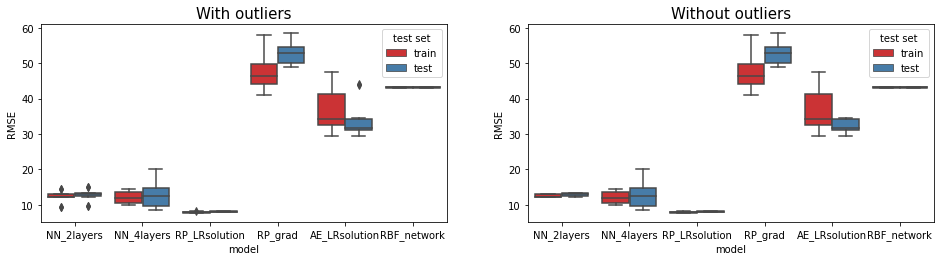

In [24]:
results_table = pd.DataFrame(columns = ['RMSE'])
for i in [RMSE_NN_2layers, RMSE_NN_4layers, RMSE_RP_LRsolution, RMSE_RP_NN_readout, 
          RMSE_AE_LRsolution, RMSE_RBF_network]:
    results_table = pd.concat([results_table, pd.DataFrame(torch.Tensor(i).view(-1,1).numpy(), columns = ['RMSE'])], axis = 0)
results_table['model'] = ['NN_2layers']*20 + ['NN_4layers']*20 + ['RP_LRsolution']*20 + ['RP_grad']*20 + ['AE_LRsolution']*20 + ['RBF_network']*20 
results_table['test set'] = (['train']*10 + ['test']*10)*6

plt.figure(figsize=(16,8))
plt.subplot(221)
sns.boxplot(x="model", y="RMSE", hue="test set", data=results_table, palette="Set1",showfliers = True)
plt.title("With outliers", fontsize=15)    

plt.subplot(222)
sns.boxplot(x="model", y="RMSE", hue="test set", data=results_table, palette="Set1",showfliers = False)
plt.title("Without outliers", fontsize=15) 

Text(0.5, 1.0, 'Without outliers')

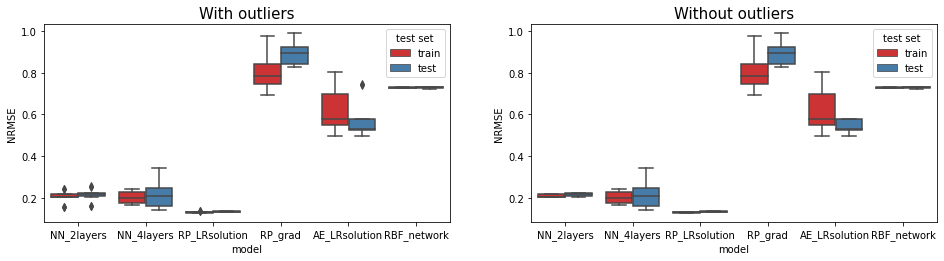

In [25]:
results_table = pd.DataFrame(columns = ['NRMSE'])
for i in [NRMSE_NN_2layers, NRMSE_NN_4layers, NRMSE_RP_LRsolution, NRMSE_RP_NN_readout, 
          NRMSE_AE_LRsolution, NRMSE_RBF_network]:
    results_table = pd.concat([results_table, pd.DataFrame(torch.Tensor(i).view(-1,1).numpy(), columns = ['NRMSE'])], axis = 0)
results_table['model'] = ['NN_2layers']*20 + ['NN_4layers']*20 + ['RP_LRsolution']*20 + ['RP_grad']*20 + ['AE_LRsolution']*20 + ['RBF_network']*20 
results_table['test set'] = (['train']*10 + ['test']*10)*6

plt.figure(figsize=(16,8))
plt.subplot(221)
sns.boxplot(x="model", y="NRMSE", hue="test set", data=results_table, palette="Set1",showfliers = True)
plt.title("With outliers", fontsize=15)    

plt.subplot(222)
sns.boxplot(x="model", y="NRMSE", hue="test set", data=results_table, palette="Set1",showfliers = False)
plt.title("Without outliers", fontsize=15) 

## Benchmark - new financial parameters without retraining randomized layer

In [0]:
dim_X = 10
Pricing_Generator = call_pricing_generator(dim_X = dim_X, r = 0.035, T = 2.)

S0_train, payoff_train, price_BS_train = Pricing_Generator.simulate(N_sim = 100000)
S0_test, payoff_test, price_BS_test = Pricing_Generator.simulate(N_sim = 100000)

X_train = (S0_train - S0_train.mean(axis = 0))/S0_train.std(axis = 0)
X_test = (S0_test - S0_train.mean(axis = 0))/S0_train.std(axis = 0)

X_train = X_train.to(device)
X_test = X_test.to(device)
payoff_train = payoff_train.to(device)
price_BS_train = price_BS_train.to(device)
payoff_test = payoff_test.to(device)
price_BS_test = price_BS_test.to(device)

y_train = payoff_train/payoff_train.std()

In [27]:
NN_pricing = NN_nlayers(Layers=[dim_X,50,50,1], activation = 'Leakyrelu').to(device)
train_quad_loss(NN_pricing, X_train = X_train, y_train = y_train, verbose = None, epochs = 200)

predict_train = payoff_train.std()*NN_pricing(X_train)
predict_test = payoff_train.std()*NN_pricing(X_test)

print('Retrain NN : in-sample : ',
      torch.sqrt(torch.mean((predict_train - price_BS_train)**2)))
print('Retrain NN : out-sample : ', 
      torch.sqrt(torch.mean((predict_test - price_BS_test)**2)))

################
LRsolution_readout.fit(RP_sigmoid_1.fit_transform(X_train), y_train)
predict_train = payoff_train.std()*LRsolution_readout.predict(RP_sigmoid_1.fit_transform(X_train))
predict_test = payoff_train.std()*LRsolution_readout.predict(RP_sigmoid_1.fit_transform(X_test))

print('Random projection - inverse matrix solution : in-sample : ',
      torch.sqrt(torch.mean((predict_train - price_BS_train)**2)))
print('Random projection - inverse matrix solution : out-sample : ', 
      torch.sqrt(torch.mean((predict_test - price_BS_test)**2)))

#################
train_quad_loss_optimal(NNgradient_readout, X_train = RP_sigmoid_2.fit_transform(X_train),
                  y_train = y_train, verbose = None)
predict_train = payoff_train.std()*NNgradient_readout(RP_sigmoid_2.fit_transform(X_train))
predict_test = payoff_train.std()*NNgradient_readout(RP_sigmoid_2.fit_transform(X_test))

print('Random projection - SGD optimizer : in-sample : ',
      torch.sqrt(torch.mean((predict_train - price_BS_train)**2)))
print('Random projection - SGD optimizer : out-sample : ',
      torch.sqrt(torch.mean((predict_test - price_BS_test)**2)))

#################
X_train_transformed = Autoencoder_NN.forward_central_layer(X_train).data
X_test_transformed = Autoencoder_NN.forward_central_layer(X_test).data
LRsolution_readout.fit(X_train_transformed, y_train)

predict_train = payoff_train.std()*LRsolution_readout.predict(X_train_transformed)
predict_test = payoff_train.std()*LRsolution_readout.predict(X_test_transformed)

print('Autoencoder - inverse matrix solution : in-sample : ',
      torch.sqrt(torch.mean((predict_train - price_BS_train)**2)))
print('Autoencoder - inverse matrix solution : out-sample : ',
      torch.sqrt(torch.mean((predict_test - price_BS_test)**2)))

#################
X_train_transformed =  RBF_hiddenlayer.transform(X_train).data
X_test_transformed =  RBF_hiddenlayer.transform(X_test).data
LRsolution_readout.fit(X_train_transformed, y_train)

predict_train = payoff_train.std()*LRsolution_readout.predict(X_train_transformed)
predict_test = payoff_train.std()*LRsolution_readout.predict(X_test_transformed)

print('RBF - inverse matrix solution : in-sample : ',
      torch.sqrt(torch.mean((predict_train - price_BS_train)**2)))
print('RBF - inverse matrix solution : out-sample : ',
      torch.sqrt(torch.mean((predict_test - price_BS_test)**2)))


Retrain NN : in-sample :  tensor(8.4381, device='cuda:0', grad_fn=<SqrtBackward>)
Retrain NN : out-sample :  tensor(8.5173, device='cuda:0', grad_fn=<SqrtBackward>)
Random projection - inverse matrix solution : in-sample :  tensor(6.1101, device='cuda:0')
Random projection - inverse matrix solution : out-sample :  tensor(6.1476, device='cuda:0')
Random projection - SGD optimizer : in-sample :  tensor(52.0510, device='cuda:0', grad_fn=<SqrtBackward>)
Random projection - SGD optimizer : out-sample :  tensor(51.8253, device='cuda:0', grad_fn=<SqrtBackward>)
Autoencoder - inverse matrix solution : in-sample :  tensor(36.1809, device='cuda:0')
Autoencoder - inverse matrix solution : out-sample :  tensor(36.0328, device='cuda:0')
RBF - inverse matrix solution : in-sample :  tensor(39.2589, device='cuda:0')
RBF - inverse matrix solution : out-sample :  tensor(38.9701, device='cuda:0')


# 5 Conditional $\mathbb{VaR}$ & $\mathbb{ES}$ problem

In [29]:
import gc
del S0_train, payoff_train, price_BS_train, S0_test, payoff_test, price_BS_test,X_train,X_test,y_train
gc.collect()

5

In [0]:
dim_X = 50
eps = 0.025
Var_Es_Generator = var_es_generator(X_dim=dim_X, eps = eps, lambda_rs = random.randint(0,2000), mu_rs= random.randint(0,2000))

X_train, Y_train, true_VaR_train, true_ES_train, mean_Y_train, std_Y_train = Var_Es_Generator.simulate(10000, lambda_0 = 30., mu_0 = 10.)
X_test, Y_test, true_VaR_test, true_ES_test, mean_Y_test, std_Y_test = Var_Es_Generator.simulate(10000, lambda_0 = 30., mu_0 = 10.)

X_train = X_train.to(device)
Y_train = Y_train.to(device)
true_VaR_train = true_VaR_train.to(device)
true_ES_train = true_ES_train.to(device)

X_test = X_test.to(device)
Y_test = Y_test.to(device)
true_VaR_test = true_VaR_test.to(device)
true_ES_test = true_ES_test.to(device)

In [0]:
def NRMSE(pred, true):
    return torch.sqrt(torch.mean((pred - true)**2))/ torch.std(true)

def plot_function(var_train_pre, var_train_true, es_train_pre, es_train_true,
                  var_test_pre, var_test_true, es_test_pre, es_test_true):
    [var_train_pre, var_train_true, es_train_pre, es_train_true,
     var_test_pre, var_test_true, es_test_pre, es_test_true]= \
     [var.cpu() for var in [var_train_pre, var_train_true, es_train_pre, es_train_true,
                            var_test_pre, var_test_true, es_test_pre, es_test_true]]

    plt.figure(figsize=(14,7))
    plt.subplot(221)
    g = sns.distplot(var_test_pre.cpu().data, label='predicted VaR')
    g = sns.distplot(var_test_true.data, label='True VaR')
    g = plt.title("out-of-sample VaR distributions", fontsize=12)
    g = plt.xlabel("")
    g = plt.ylabel("Probability", fontsize=15)
    g = plt.legend()

    plt.subplot(222)
    g = sns.distplot(es_test_pre.data, label='predicted ES')
    g = sns.distplot(es_test_true.data, label='True ES')
    g = plt.title("out-of-sample ES distributions", fontsize=12)
    g = plt.xlabel("")
    g = plt.ylabel("Probability", fontsize=15)
    g = plt.legend()

    plt.figure(figsize=(12,10))
    plt.subplot(321)
    d = pd.DataFrame(np.concatenate([(var_train_pre - var_train_true).detach().numpy(),
                                     (var_test_pre - var_test_true).detach().numpy()]), columns = ['error'])
    d['sample'] = ['train']*len(var_train_pre) + ['test']*len(var_train_pre)
    g = sns.violinplot(x = 'sample', y = 'error', data=d, palette="Set1")
    g = plt.title("Violinplot VaR error", fontsize=12)

    plt.subplot(322)
    d = pd.DataFrame(np.concatenate([(es_train_pre - es_train_true).detach().numpy(),
                                     (es_test_pre - es_test_true).detach().numpy()]), columns = ['error'])
    d['sample'] = ['train']*len(var_train_pre) + ['test']*len(var_train_pre)
    g = sns.violinplot(x = 'sample', y = 'error', data=d, palette="Set1")
    g = plt.title("Violinplot ES error", fontsize=12)

    print('NRMSE in-sample VaR: ',NRMSE(var_train_pre.data, var_train_true.data))
    print('NRMSE in-sample ES: ',NRMSE(es_train_pre.data, es_train_true.data))
    print('NRMSE out-sample VaR: ',NRMSE(var_test_pre.data, var_test_true.data))
    print('NRMSE out-sample ES: ',NRMSE(es_test_pre.data, es_test_true.data))

## 5.1 Rockafellar and Urysev based

In [0]:
def train_var_RUbased(model_var, X_train_var, y_train, eps = eps,
                    epochs=300, stop_eps = 1e-8, verbose = None) :
    optimizer_var = torch.optim.Adam(model_var.parameters(), lr=0.1)
    zero_vector = torch.zeros_like(y_train)
    i = 0
    err, best_err = np.inf, np.inf
    if verbose != None:
        print('===Train VaR process===')
    while (err > stop_eps) and (i < epochs):
        optimizer_var.zero_grad()
        q = model_var(X_train_var)
        if eps != 0.5:
            loss_var = torch.mean( 1/eps*torch.max(y_train - q, zero_vector) + q )
        else:
            loss_var = torch.mean((1-eps)*torch.max(y_train - q, zero_vector) + eps*torch.max(q-y_train, zero_vector))       
        if err < best_err:
            best_err = err
            torch.save(model_var.state_dict(), 'best') 
        loss_var.backward()
        optimizer_var.step()
        err = loss_var.data.item()
        if verbose != None : 
            if i % verbose == 0:
                print('[iter {}] err = {}'.format(i, round(err, 3)))
        i += 1
    if verbose != None : 
        print('[iter {}] err = {}'.format(i, round(err, 3)))
    model_var.load_state_dict(torch.load('best'))
    model_var.eval()

def train_var_RUbased_NW(model_var, X_train_var, y_train, eps = eps,
                    epochs=300, stop_eps = 1e-8, verbose = None) :
    optimizer_var = torch.optim.LBFGS(model_var.parameters())
    zero_vector = torch.zeros_like(y_train)
    i = 0
    err, best_err = np.inf, np.inf
    if verbose != None:
        print('===Train VaR process===')
    while (err > stop_eps) and (i < epochs):
        def closure():
            model_var.zero_grad()
            q = model_var(X_train_var)
            loss_var = torch.mean( 1/eps*torch.max(y_train - q, zero_vector) + q )
            #loss_var = torch.mean(((y_train < q)*1 - eps)*g1_func(q) - (y_train < q)*1*g1_func(y_train))       
            loss_var.backward()
            return loss_var
        optimizer_var.step(closure)
        err = closure().data.item()
        if err < best_err:
            best_err = err
            torch.save(model_var.state_dict(), 'best') 
        if verbose != None : 
            if i % verbose == 0:
                print('[iter {}] err = {}'.format(i, round(err, 3)))
        i += 1
    if verbose != None : 
        print('[iter {}] err = {}'.format(i, round(err, 3)))
    model_var.load_state_dict(torch.load('best'))
    model_var.eval()

def train_var_RUbased_2q(model_var, X_train_var, y_train, eps_list = [eps,0.5, 0.975],
                    epochs=300, stop_eps = 1e-8, verbose = None) :
    optimizer_var = torch.optim.Adam(model_var.parameters(), lr=0.1)
    zero_vector = torch.zeros_like(y_train)
    i = 0
    err, best_err = np.inf, np.inf
    if verbose != None:
        print('===Train VaR process===')
    while (err > stop_eps) and (i < epochs):
        optimizer_var.zero_grad()
        loss_var = torch.tensor(0.)
        q_i = model_var(X_train_var)
        loss_var = torch.sum(torch.mean(1/torch.tensor(eps_list).to(device)*torch.max(y_train - q_i, zero_vector) + q_i, 0))
        #loss_var = torch.mean(((y_train < q)*1 - eps)*g1_func(q) - (y_train < q)*1*g1_func(y_train))
        if err < best_err:
            best_err = err
            torch.save(model_var.state_dict(), 'best')     
        loss_var.backward()
        optimizer_var.step()
        err = loss_var.data.item()
        if verbose != None : 
            if i % verbose == 0:
                print('[iter {}] err = {}'.format(i, round(err, 3)))
        i += 1
    if verbose != None : 
        print('[iter {}] err = {}'.format(i, round(err, 3)))
    model_var.load_state_dict(torch.load('best'))
    model_var.eval()


def train_es_RUbased(q_train, model_es, X_train_es, y_train, eps = 0.025,
                   epochs=300, stop_eps = 1e-8, verbose = None, lr = 0.1) :

    optimizer_es = torch.optim.Adam(model_es.parameters(), lr=lr)
    zero_vector = torch.zeros_like(y_train)
    i = 0
    err, best_err = np.inf, np.inf

    if verbose != None:
        print('===Train ES process===')
    while (abs(err) > stop_eps) and (i < epochs):
        optimizer_es.zero_grad()
        e = model_es.forward(X_train_es)
        loss_es = torch.mean( (1/eps*torch.max(y_train - q_train, zero_vector) + q_train -e)**2 )
        #loss_es = torch.mean(g2_dot_func(e)*(e - q_train + 1/eps*(q_train - y_train))*((y_train < q_train)*1) - g2_func(e)) 
        if err < best_err:
            best_err = err
            torch.save(model_es.state_dict(), 'best')   
        loss_es.backward()
        optimizer_es.step()
        err = loss_es.data.item()
        if verbose != None : 
            if i % verbose == 0:
                print('[iter {}] err = {}'.format(i, round(err, 3)))
        i += 1
    if verbose != None : 
        print('[iter {}] err = {}'.format(i, round(err, 3)))

    model_es.load_state_dict(torch.load('best'))
    model_es.eval()

### 1 hidden layer of 100 units networks without randomized layers

===Train VaR process===
[iter 0] err = 1906.11
[iter 50] err = 157.857
[iter 100] err = 135.709
[iter 150] err = 129.716
[iter 200] err = 125.401
[iter 250] err = 121.723
[iter 300] err = 118.279
[iter 350] err = 115.074
[iter 400] err = 112.48
[iter 450] err = 110.307
[iter 500] err = 108.098
[iter 550] err = 106.254
[iter 600] err = 104.894
[iter 650] err = 103.278
[iter 700] err = 102.346
[iter 750] err = 101.367
[iter 800] err = 99.92
[iter 850] err = 98.647
[iter 900] err = 97.401
[iter 950] err = 96.822
[iter 1000] err = 95.921

 VaR Computation:  1.6779663562774658
===Train ES process===
[iter 0] err = 11766.184
[iter 50] err = 1371.767
[iter 100] err = 1159.689
[iter 150] err = 984.369
[iter 200] err = 838.583
[iter 250] err = 734.712
[iter 300] err = 660.239

 ES Computation:  0.5443716049194336
NRMSE in-sample VaR:  tensor(0.8681)
NRMSE in-sample ES:  tensor(0.9039)
NRMSE out-sample VaR:  tensor(0.9347)
NRMSE out-sample ES:  tensor(0.9319)


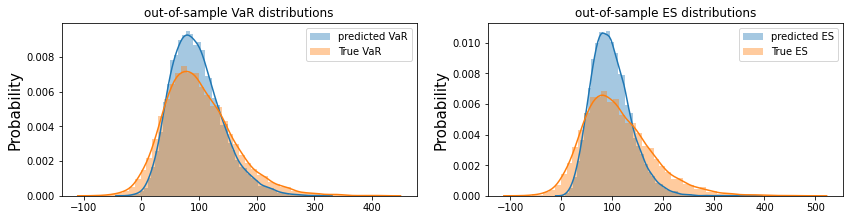

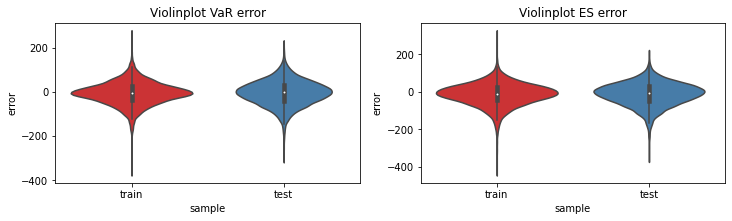

In [33]:
p1 = time.time()

var_NN = NN_nlayers(Layers=[dim_X,100,1], activation = 'relu').to(device)
es_NN = NN_nlayers(Layers=[dim_X,100,1], activation = 'relu').to(device)

train_var_RUbased(var_NN, X_train_var= X_train, y_train= Y_train, eps = eps,
                epochs = 1000, stop_eps = 1e-8, verbose = 50)

print('\n VaR Computation: ', time.time() - p1)#132
p1 = time.time()

q_pred = var_NN(X_train).data
q_pred_test = var_NN(X_test).data
train_es_RUbased(q_pred, es_NN, X_train_es = X_train, y_train = Y_train, eps = eps,
               epochs = 300,verbose = 50)

print('\n ES Computation: ', time.time() - p1)

plot_function(var_NN(X_train), true_VaR_train,
              es_NN(X_train), true_ES_train,
              var_NN(X_test), true_VaR_test,
              es_NN(X_test), true_ES_test)

### Newton method optimisation

In [35]:
p1 = time.time()

var_NN = NN_nlayers(Layers=[dim_X,100,1], activation = 'relu').to(device)
es_NN = NN_nlayers(Layers=[dim_X,100,1], activation = 'relu').to(device)

train_var_RUbased_NW(var_NN, X_train_var= X_train, y_train= Y_train, 
                epochs = 300, stop_eps = 1e-8, verbose = 50)

print('\n VaR Computation: ', time.time() - p1)#132
p1 = time.time()

q_pred = var_NN(X_train).data
q_pred_test = var_NN(X_test).data
train_es_RUbased(q_pred, es_NN, X_train_es = X_train, y_train = Y_train, eps = 0.025,
               epochs = 300,verbose = 50)

print('\n ES Computation: ', time.time() - p1)

===Train VaR process===
[iter 0] err = 116.185
[iter 50] err = 88.11
[iter 100] err = 86.414
[iter 150] err = 85.766
[iter 200] err = 85.353
[iter 250] err = 85.127
[iter 300] err = 84.962

 VaR Computation:  110.21031332015991
===Train ES process===
[iter 0] err = 8579.931
[iter 50] err = 761.631
[iter 100] err = 667.781
[iter 150] err = 595.178
[iter 200] err = 535.271
[iter 250] err = 485.772
[iter 300] err = 447.103

 ES Computation:  0.525482177734375


NRMSE in-sample VaR:  tensor(0.8987)
NRMSE in-sample ES:  tensor(0.9482)
NRMSE out-sample VaR:  tensor(0.9878)
NRMSE out-sample ES:  tensor(0.9651)


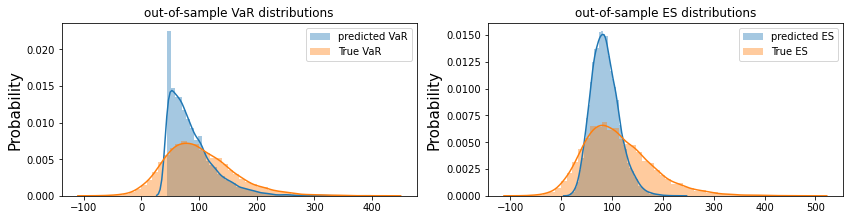

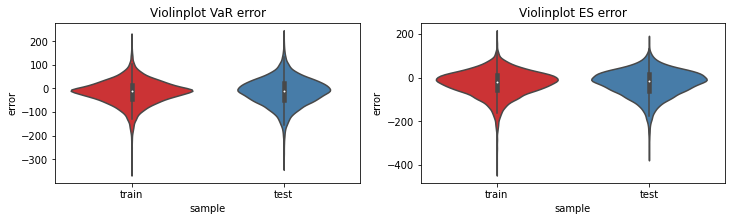

In [36]:
plot_function(var_NN(X_train), true_VaR_train,
              es_NN(X_train), true_ES_train,
              var_NN(X_test), true_VaR_test,
              es_NN(X_test), true_ES_test)

### 3 quantiles output

In [47]:
p1 = time.time()

var_NN = NN_nlayers(Layers=[dim_X,100,8], activation = 'relu').to(device)
es_NN = NN_nlayers(Layers=[dim_X,100,1], activation = 'relu').to(device)

train_var_RUbased_2q(var_NN, X_train_var= X_train, y_train= Y_train, eps_list=[eps, 0.1,0.15,0.2,0.25, 0.3,0.4,0.5],
                epochs = 500, stop_eps = 1e-8, verbose = 50)

print('\n VaR Computation: ', time.time() - p1)#132
p1 = time.time()

q_pred = var_NN(X_train)[:,0:1].data
q_pred_test = var_NN(X_test)[:,0:1].data


===Train VaR process===
[iter 0] err = 3517.146
[iter 50] err = 822.368
[iter 100] err = 781.835
[iter 150] err = 759.505
[iter 200] err = 739.91
[iter 250] err = 714.468
[iter 300] err = 675.96
[iter 350] err = 651.398
[iter 400] err = 637.203
[iter 450] err = 626.459
[iter 500] err = 621.522

 VaR Computation:  0.9697840213775635


NRMSE in-sample VaR:  tensor(0.8372)
NRMSE in-sample ES:  tensor(0.)
NRMSE out-sample VaR:  tensor(0.9139)
NRMSE out-sample ES:  tensor(0.)


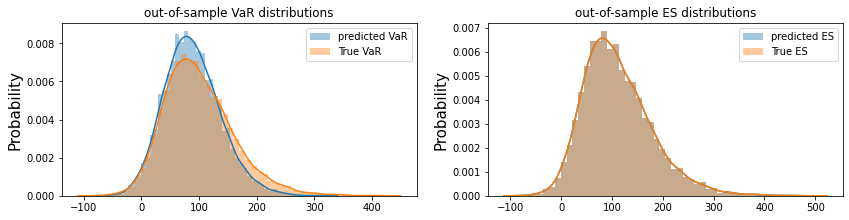

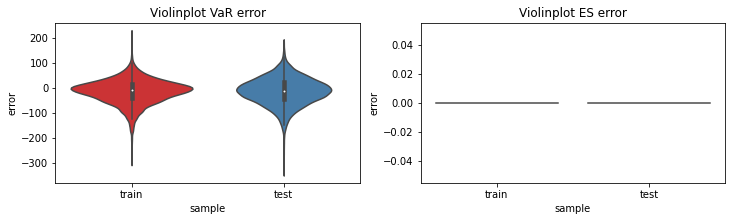

In [48]:
plot_function(q_pred, true_VaR_train,
              true_ES_train, true_ES_train,
              q_pred_test, true_VaR_test,
              true_ES_test, true_ES_test)

### 3 hidden layer of 100 units networks without randomized layers

In [49]:
p1 = time.time()

var_NN = NN_nlayers(Layers=[dim_X,100,100,100,1], activation = 'relu').to(device)
es_NN = NN_nlayers(Layers=[dim_X,100,100,100,1], activation = 'relu').to(device)

train_var_RUbased(var_NN, X_train_var= X_train, y_train= Y_train, 
                epochs = 1000, stop_eps = 1e-8, verbose = 50)

print('\n VaR Computation: ', time.time() - p1)#132
p1 = time.time()

q_pred = var_NN(X_train).data
q_pred_test = var_NN(X_test).data
train_es_RUbased(q_pred, es_NN, X_train_es = X_train, y_train = Y_train, eps = 0.025,
               epochs = 300,verbose = 50)

print('\n ES Computation: ', time.time() - p1)

===Train VaR process===
[iter 0] err = 1912.682
[iter 50] err = 138.497
[iter 100] err = 124.37
[iter 150] err = 128.274
[iter 200] err = 117.687
[iter 250] err = 125.255
[iter 300] err = 140.307
[iter 350] err = 102.227
[iter 400] err = 100.686
[iter 450] err = 111.953
[iter 500] err = 107.482
[iter 550] err = 90.255
[iter 600] err = 102.095
[iter 650] err = 113.644
[iter 700] err = 84.175
[iter 750] err = 94.46
[iter 800] err = 85.371
[iter 850] err = 81.697
[iter 900] err = 90.696
[iter 950] err = 77.288
[iter 1000] err = 83.285

 VaR Computation:  2.376462697982788
===Train ES process===
[iter 0] err = 8391.354
[iter 50] err = 1534.047
[iter 100] err = 844.681
[iter 150] err = 594.778
[iter 200] err = 342.833
[iter 250] err = 327.565
[iter 300] err = 306.48

 ES Computation:  0.7986314296722412


NRMSE in-sample VaR:  tensor(0.9034)
NRMSE in-sample ES:  tensor(0.9773)
NRMSE out-sample VaR:  tensor(0.9863)
NRMSE out-sample ES:  tensor(1.0373)


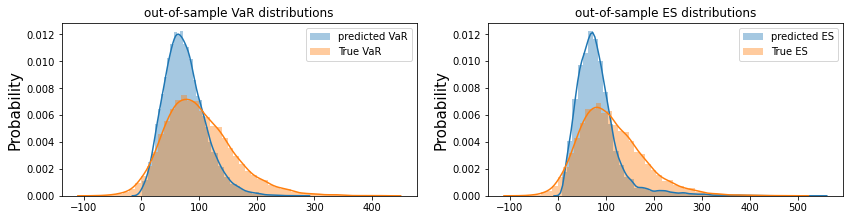

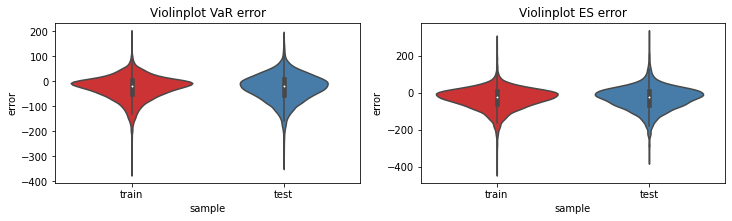

In [50]:
plot_function(q_pred, true_VaR_train,
              es_NN(X_train), true_ES_train,
              q_pred_test, true_VaR_test,
              es_NN(X_test), true_ES_test)

### Randomized layer and inverse matrix solution for $\mathbb{ES}$



In [51]:
p1 = time.time()

RP_100layers_relu = Randomprojection(Layers=[dim_X,500], random_state= None, activation= 'sigmoid')
var_NN = NN_nlayers(Layers=[500,1], activation = 'relu').to(device)

train_var_RUbased(var_NN, X_train_var= RP_100layers_relu.fit_transform(X_train), y_train= Y_train,
                  eps = eps, epochs = 500, stop_eps = 1e-8, verbose = 50)

print('\n Var Computation: ', time.time() - p1)

===Train VaR process===
[iter 0] err = 1921.357
[iter 50] err = 199.936
[iter 100] err = 180.793
[iter 150] err = 179.868
[iter 200] err = 179.164
[iter 250] err = 178.549
[iter 300] err = 177.97
[iter 350] err = 177.403
[iter 400] err = 176.871
[iter 450] err = 176.343
[iter 500] err = 175.842

 Var Computation:  0.6343626976013184


NRMSE in-sample VaR:  tensor(1.2600)
NRMSE in-sample ES:  tensor(0.)
NRMSE out-sample VaR:  tensor(1.2617)
NRMSE out-sample ES:  tensor(0.)


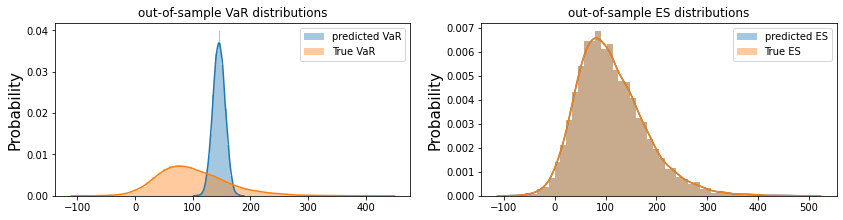

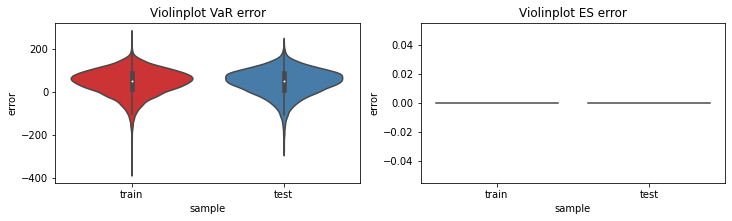

In [52]:
plot_function(var_NN(RP_100layers_relu.fit_transform(X_train)), true_VaR_train,
              true_ES_train, true_ES_train,
              var_NN(RP_100layers_relu.fit_transform(X_test)), true_VaR_test,
              true_ES_test, true_ES_test)

In [53]:
p1 = time.time()

zero_vector = torch.zeros_like(Y_train)
eps = 0.025

RP_100layers_relu = Randomprojection(Layers=[dim_X,100], random_state= None, activation= 'relu')
LRsolution_readout = LR_readout()
LRsolution_readout.fit(RP_100layers_relu.fit_transform(X_train), 
                       1/eps*torch.max(Y_train - q_pred, zero_vector)+ q_pred)
print('\n ES Computation: ', time.time() - p1)


 ES Computation:  0.060922861099243164


NRMSE in-sample VaR:  tensor(0.9034)
NRMSE in-sample ES:  tensor(1.0866)
NRMSE out-sample VaR:  tensor(0.9863)
NRMSE out-sample ES:  tensor(1.0905)


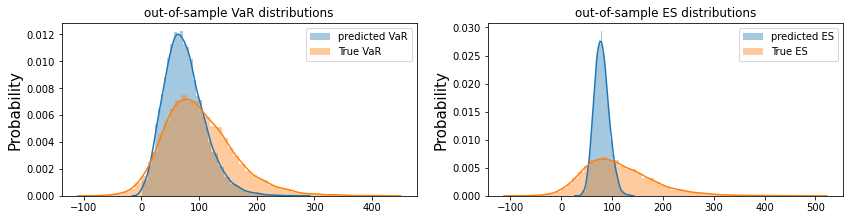

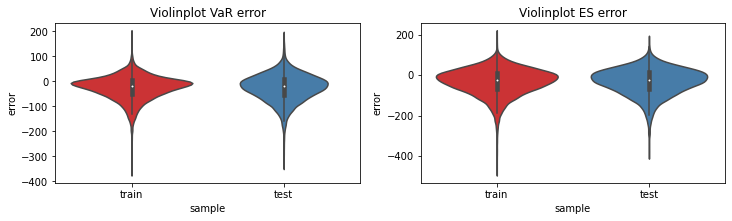

In [54]:
plot_function(q_pred, true_VaR_train,
              LRsolution_readout.predict(RP_100layers_relu.fit_transform(X_train)), true_ES_train,
              q_pred_test, true_VaR_test,
              LRsolution_readout.predict(RP_100layers_relu.fit_transform(X_test)), true_ES_test)

### RP 3 quantiles output

In [55]:
p1 = time.time()

zero_vector = torch.zeros_like(Y_train)
eps = 0.025

RP_100layers_relu = Randomprojection(Layers=[dim_X,100], random_state= None, activation= 'relu')
var_NN = NN_nlayers(Layers=[100,3], activation = 'relu').to(device)

train_var_RUbased_2q(var_NN, X_train_var= RP_100layers_relu.fit_transform(X_train), y_train= Y_train, 
                epochs = 300, stop_eps = 1e-8, verbose = 50) 

q_pred = var_NN(RP_100layers_relu.fit_transform(X_train))[:,1:2].data
LRsolution_readout = LR_readout()
LRsolution_readout.fit(RP_100layers_relu.fit_transform(X_train), 
                       1/eps*torch.max(Y_train - q_pred, zero_vector)+ q_pred)
print('\n ES Computation: ', time.time() - p1)

===Train VaR process===
[iter 0] err = 2032.681
[iter 50] err = 324.485
[iter 100] err = 305.068
[iter 150] err = 302.375
[iter 200] err = 300.938
[iter 250] err = 300.027
[iter 300] err = 299.365

 ES Computation:  0.45731043815612793


NRMSE in-sample VaR:  tensor(1.3738)
NRMSE in-sample ES:  tensor(10.8207)
NRMSE out-sample VaR:  tensor(1.3815)
NRMSE out-sample ES:  tensor(10.7708)


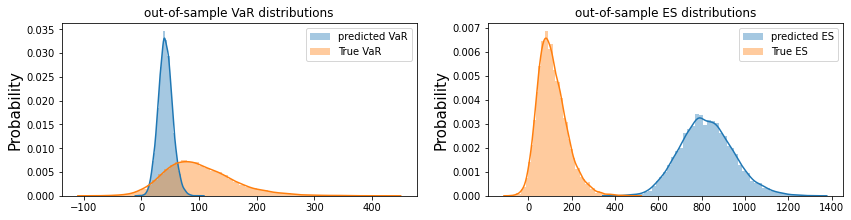

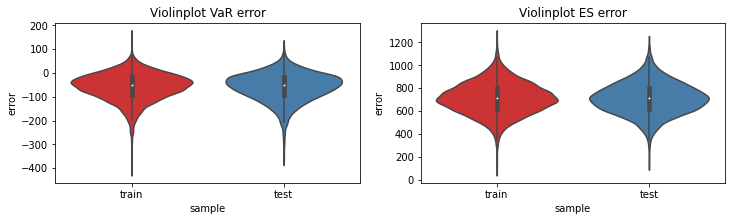

In [56]:
plot_function(q_pred, true_VaR_train,
              LRsolution_readout.predict(RP_100layers_relu.fit_transform(X_train)), true_ES_train,
              var_NN(RP_100layers_relu.fit_transform(X_test))[:,1:2].data, true_VaR_test,
              LRsolution_readout.predict(RP_100layers_relu.fit_transform(X_test)), true_ES_test)

### Autoencoder and inverse matrix solution for $\mathbb{ES}$

In [57]:
p1 = time.time()
Autoencoder_NN = Autoencoder(Layers=[dim_X,100,150,200], activation = 'relu').to(device)
train_quad_loss(Autoencoder_NN, X_train = X_train,
              y_train = X_train, verbose = None, epochs = 100)

X_train_transformed = Autoencoder_NN.forward_central_layer(X_train).data
X_test_transformed = Autoencoder_NN.forward_central_layer(X_test).data

LRsolution_readout = LR_readout()
LRsolution_readout.fit(X_train_transformed, 
                       1/eps*torch.max(Y_train - q_pred, zero_vector)+ q_pred)

print('\n ES Computation: ', time.time() - p1)


 ES Computation:  0.6661019325256348


NRMSE in-sample VaR:  tensor(1.3738)
NRMSE in-sample ES:  tensor(204.5202)
NRMSE out-sample VaR:  tensor(0.9863)
NRMSE out-sample ES:  tensor(600878.1250)


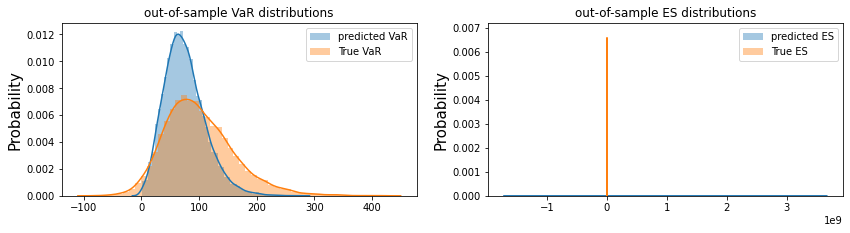

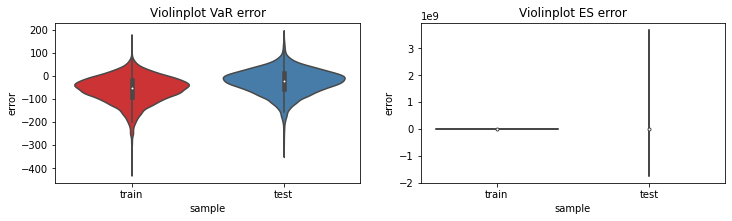

In [58]:
plot_function(q_pred, true_VaR_train,
              LRsolution_readout.predict(X_train_transformed), true_ES_train,
              q_pred_test, true_VaR_test,
              LRsolution_readout.predict(X_test_transformed), true_ES_test)

### RBF network

In [59]:
p1 = time.time()
RBF_hiddenlayer = RBFlayer(output_layer =200, function ='thin plate spline', e = 0.2)
RBF_hiddenlayer.fit(X_train)

X_train_transformed = RBF_hiddenlayer.transform(X_train).data
X_test_transformed = RBF_hiddenlayer.transform(X_test).data

LRsolution_readout = LR_readout(normalize=True)
LRsolution_readout.fit(X_train_transformed, 
                       1/eps*torch.max(Y_train - q_pred, zero_vector)+ q_pred)

print('\n ES Computation: ', time.time() - p1)


 ES Computation:  0.40344953536987305


NRMSE in-sample VaR:  tensor(1.3738)
NRMSE in-sample ES:  tensor(11.6647)
NRMSE out-sample VaR:  tensor(0.9863)
NRMSE out-sample ES:  tensor(11.5506)


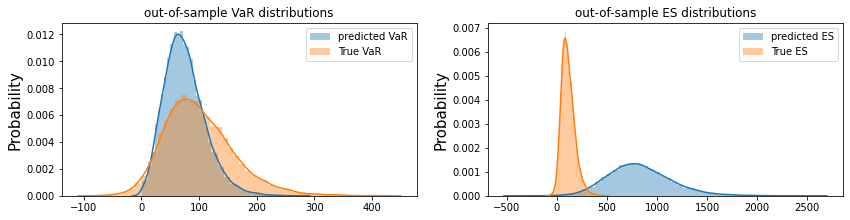

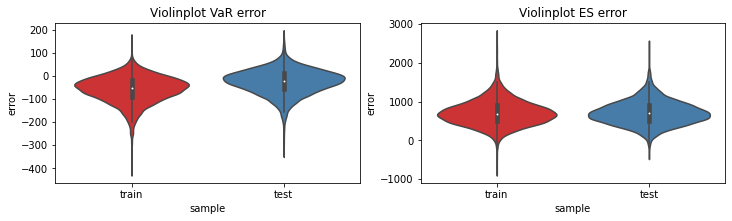

In [60]:
plot_function(q_pred, true_VaR_train,
              LRsolution_readout.predict(X_train_transformed), true_ES_train,
              q_pred_test, true_VaR_test,
              LRsolution_readout.predict(X_test_transformed), true_ES_test)

## 5.2 Joint approach

In [0]:
def g1(x):
    return x

def g2(x):
    #return -torch.pow(x,2)
    return -torch.log(1 + torch.exp(-x))

def g2_dot(x):
    #return -2*x
    return  torch.exp(-x)/(1 + torch.exp(-x))

g1_list = [lambda x: x,
           lambda x: torch.zeros_like(x)]

g2_list = [lambda x: -torch.log(-x),
           lambda x: - torch.sqrt(-x),
           lambda x: -1/x,
           lambda x: torch.log(1+torch.exp(x)),
           lambda x: torch.exp(x)]

g2_dot_list = [lambda x: -1/x,
               lambda x: 0.5/torch.sqrt(-x),
               lambda x: 1/torch.pow(x,2),
               lambda x: torch.exp(x)/(1+ torch.exp(x)),
               lambda x: torch.exp(x)
               ]
zip_g_list = zip(g1_list*5, g2_list*2, g2_dot_list*2)

In [0]:
def joint_train_var_es_model(model_var, model_es, X_train_var, X_train_es, y_train, 
                             eps = 0.025, g1_func = g1, g2_func = g2, g2_dot_func = g2_dot,
                             epochs=300, stop_eps = 1e-8, verbose = None) :
    optimizer = torch.optim.Adam(list(model_var.parameters()) + list(model_es.parameters()), lr=0.1)
    i = 0
    err = np.inf
    zero_vector = torch.zeros_like(y_train)
    while (abs(err) > stop_eps) and (i < epochs):
        optimizer.zero_grad()
        q = model_var.forward(X_train_var)
        e = model_es.forward(X_train_es)
        loss = torch.mean(1/eps*torch.max(g1_func(y_train) - g1_func(q), zero_vector) + g1_func(q) +
                           g2_func(e) - g2_dot_func(e)*(e - q - 1/eps*torch.max(y_train - q, zero_vector)) )
        #loss = torch.mean(((y_train < q)*1 - eps)*g1_func(q) - (y_train < q)*1*g1_func(y_train) +
        #                  g2_dot_func(e)*(e - q + 1/eps*(q - y_train))*((y_train < q)*1) - g2_func(e))
                          
        loss.backward()
        optimizer.step()
        err = loss.data.item()
        if verbose != None : 
            if i % verbose == 0:
                print('[iter {}] err = {}'.format(i, round(err, 3)))
        i += 1
    if verbose != None : 
        print('[iter {}] err = {}'.format(i, round(err, 3)))

def joint_train_var_es_model_v2(model_var, model_es, X_train_var, X_train_es, y_train, 
                             eps = 0.025, g1_func = g1, g2_func = g2, g2_dot_func = g2_dot,
                             epochs=300, stop_eps = 1e-8, verbose = None) :
    optimizer = torch.optim.Adam(list(model_var.parameters()) + list(model_es.parameters()), lr=0.1)
    i = 0
    err = np.inf
    zero_vector = torch.zeros_like(y_train)
    while (abs(err) > stop_eps) and (i < epochs):
        optimizer.zero_grad()
        q = model_var.forward(X_train_var)
        e = model_es.forward(X_train_es)
        #loss = torch.mean(1/eps*torch.max(g1_func(y_train) - g1_func(q), zero_vector) + g1_func(q) +
        #                   g2_func(e) - g2_dot_func(e)*(e - q - 1/eps*torch.max(y_train - q, zero_vector)) )
        loss = torch.mean(((y_train < q)*1 - eps)*g1_func(q) - (y_train < q)*1*g1_func(y_train) +
                          g2_dot_func(e)*(e - q + 1/eps*(q - y_train)*((y_train < q)*1)) - g2_func(e))
                          
        loss.backward()
        optimizer.step()
        err = loss.data.item()
        if verbose != None : 
            if i % verbose == 0:
                print('[iter {}] err = {}'.format(i, round(err, 3)))
        i += 1
    if verbose != None : 
        print('[iter {}] err = {}'.format(i, round(err, 3)))

### 1 hidden layer of 100 units networks without randomized layers (as slide)

In [65]:
p1 = time.time()

var_NN = NN_nlayers(Layers=[dim_X,100,1]).to(device)
es_NN = NN_nlayers(Layers=[dim_X,100,1]).to(device)

joint_train_var_es_model(var_NN, es_NN, X_train_var = X_train, X_train_es = X_train,
                         y_train = Y_train, verbose = 50, epochs = 300)

print('\n Computation: ', time.time() - p1)


[iter 0] err = 3025.438
[iter 50] err = 155.918
[iter 100] err = 135.302
[iter 150] err = 129.254
[iter 200] err = 124.692
[iter 250] err = 120.976
[iter 300] err = 117.083

 Computation:  0.8602049350738525


NRMSE in-sample VaR:  tensor(0.9099)
NRMSE in-sample ES:  tensor(1.0420)
NRMSE out-sample VaR:  tensor(0.9365)
NRMSE out-sample ES:  tensor(1.0357)


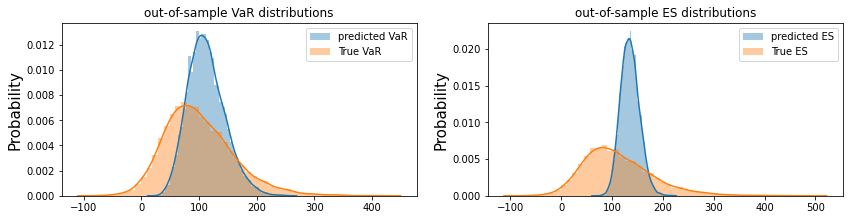

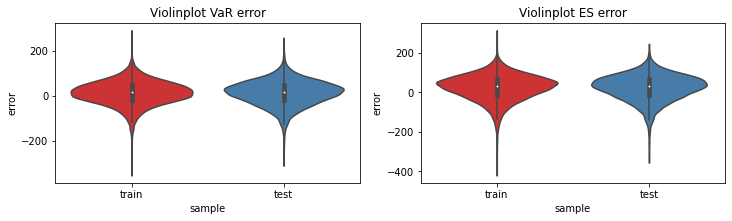

In [66]:
plot_function(var_NN(X_train), true_VaR_train,
              es_NN(X_train), true_ES_train,
              var_NN(X_test), true_VaR_test,
              es_NN(X_test), true_ES_test)

NRMSE in-sample VaR:  tensor(1.9144)
NRMSE in-sample ES:  tensor(1.9868)
NRMSE out-sample VaR:  tensor(1.9116)
NRMSE out-sample ES:  tensor(1.9833)


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


NRMSE in-sample VaR:  tensor(nan)
NRMSE in-sample ES:  tensor(nan)
NRMSE out-sample VaR:  tensor(nan)
NRMSE out-sample ES:  tensor(nan)
NRMSE in-sample VaR:  tensor(3.6534)
NRMSE in-sample ES:  tensor(3.4784)
NRMSE out-sample VaR:  tensor(3.6604)
NRMSE out-sample ES:  tensor(3.4766)
NRMSE in-sample VaR:  tensor(2.5487)
NRMSE in-sample ES:  tensor(2.4379)
NRMSE out-sample VaR:  tensor(2.5397)
NRMSE out-sample ES:  tensor(2.4297)
NRMSE in-sample VaR:  tensor(2.6750)
NRMSE in-sample ES:  tensor(3.5195)
NRMSE out-sample VaR:  tensor(2.6593)
NRMSE out-sample ES:  tensor(3.4956)
NRMSE in-sample VaR:  tensor(1.9757)
NRMSE in-sample ES:  tensor(1.9901)
NRMSE out-sample VaR:  tensor(1.9719)
NRMSE out-sample ES:  tensor(1.9863)
NRMSE in-sample VaR:  tensor(nan)
NRMSE in-sample ES:  tensor(nan)
NRMSE out-sample VaR:  tensor(nan)
NRMSE out-sample ES:  tensor(nan)


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


NRMSE in-sample VaR:  tensor(3.9021)
NRMSE in-sample ES:  tensor(2.5335)
NRMSE out-sample VaR:  tensor(3.8615)
NRMSE out-sample ES:  tensor(2.5595)
NRMSE in-sample VaR:  tensor(2.4867)
NRMSE in-sample ES:  tensor(3.6669)
NRMSE out-sample VaR:  tensor(2.4702)
NRMSE out-sample ES:  tensor(3.6420)
NRMSE in-sample VaR:  tensor(2.4598)
NRMSE in-sample ES:  tensor(2.3910)
NRMSE out-sample VaR:  tensor(2.4531)
NRMSE out-sample ES:  tensor(2.3827)


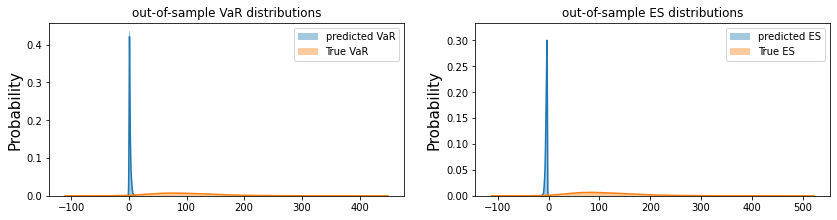

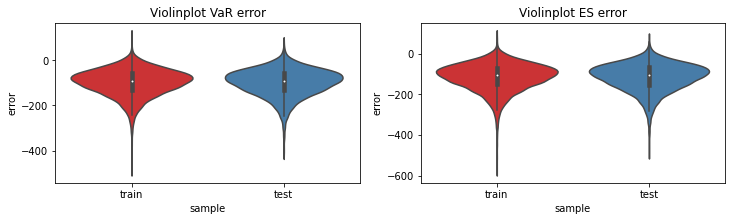

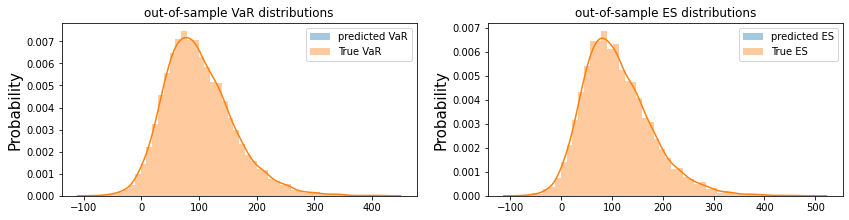

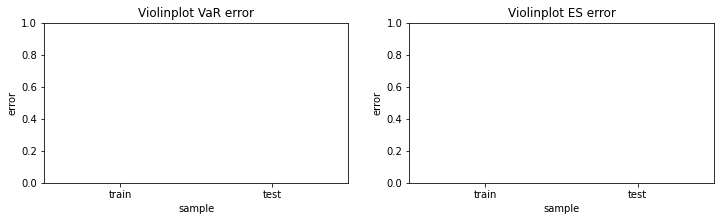

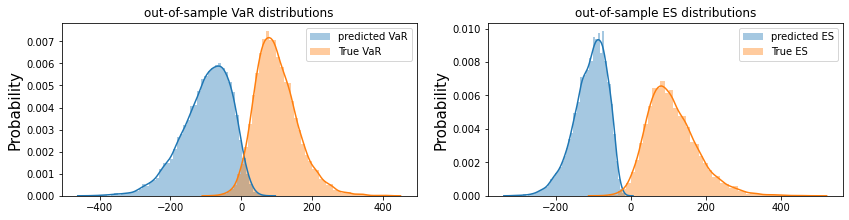

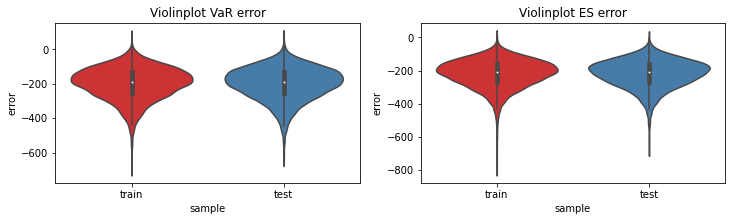

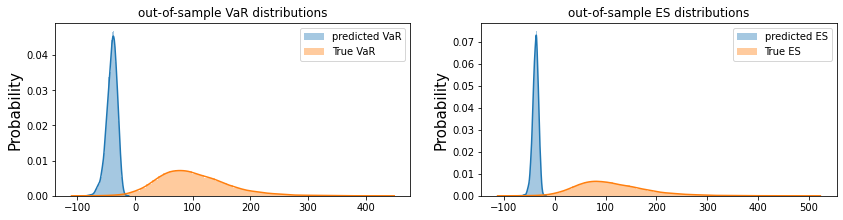

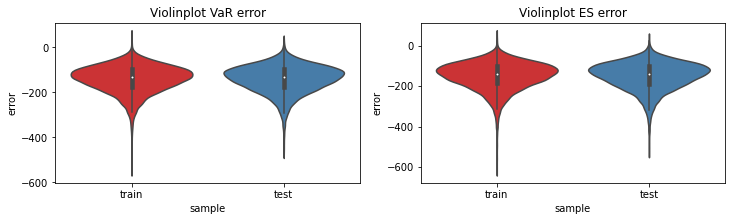

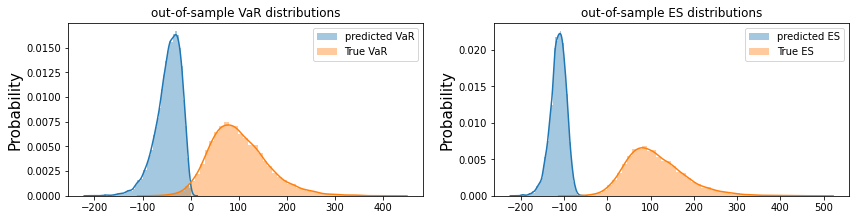

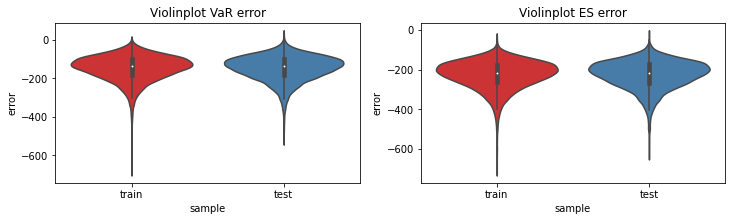

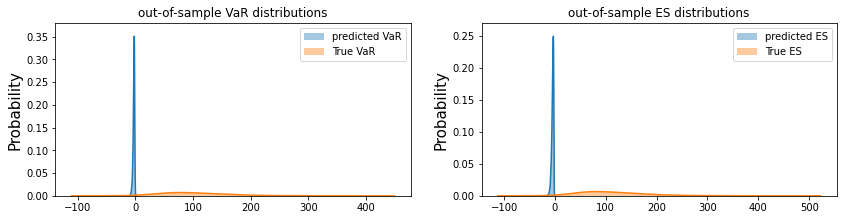

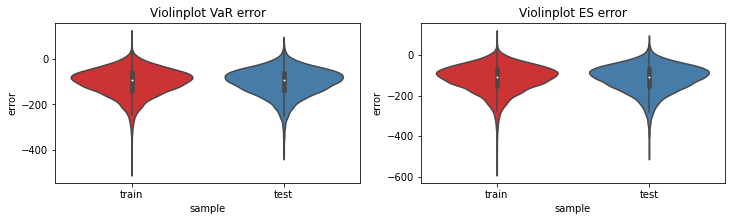

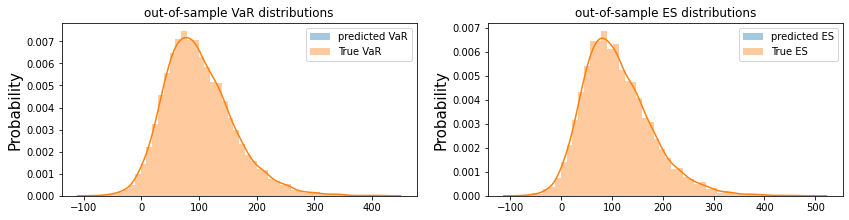

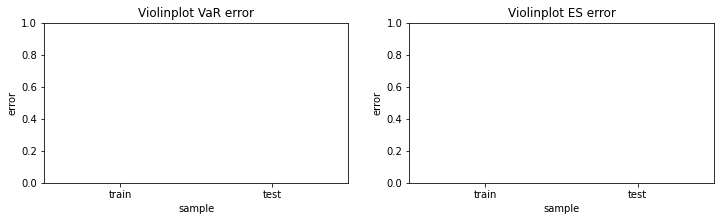

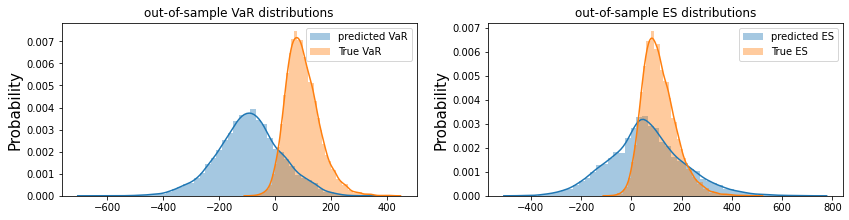

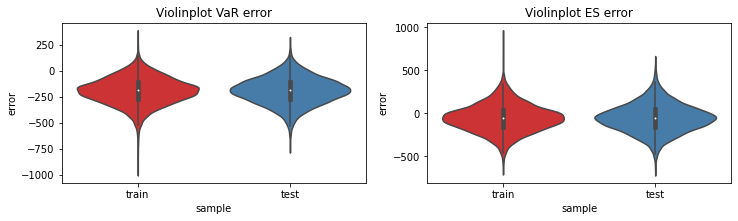

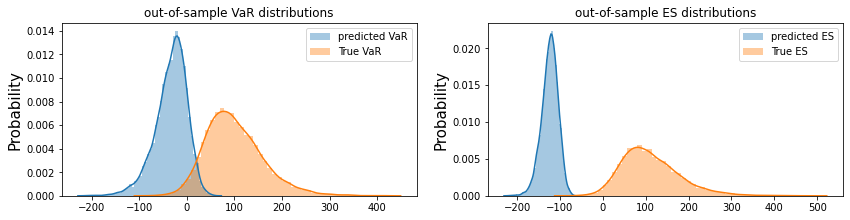

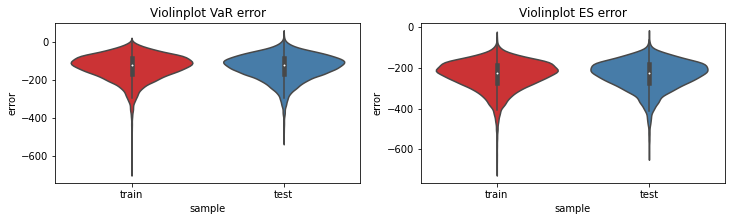

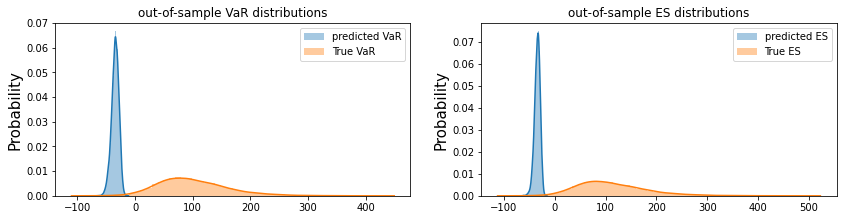

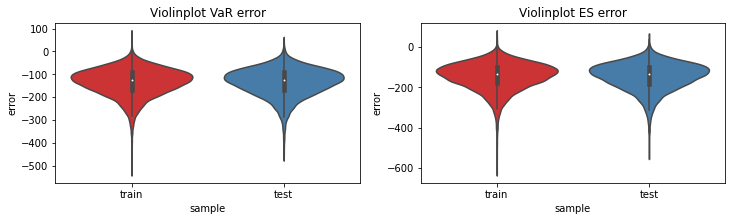

In [67]:
for g1_, g2_, g2_dot_ in zip_g_list:
    var_NN = NN_nlayers(Layers=[dim_X,100,1]).to(device)
    es_NN = NN_nlayers(Layers=[dim_X,100,1]).to(device)

    joint_train_var_es_model_v2(var_NN, es_NN, 
                             X_train_var = X_train, X_train_es = X_train,
                             y_train = Y_train,
                             g1_func = g1_, g2_func = g2_, g2_dot_func = g2_dot_,
                             verbose = None, epochs = 300)
    plot_function(var_NN(X_train), true_VaR_train,
              es_NN(X_train), true_ES_train,
              var_NN(X_test), true_VaR_test,
              es_NN(X_test), true_ES_test)


### 3 hidden layers networks without randomized layers (as XVA paper)

In [68]:
p1 = time.time()

var_NN = NN_nlayers(Layers=[dim_X,20,20,20,1]).to(device)
es_NN = NN_nlayers(Layers=[dim_X,20,20,20,1]).to(device)

joint_train_var_es_model(var_NN, es_NN, X_train_var = X_train, 
                         X_train_es = X_train,
                         y_train = Y_train, verbose = 50, epochs = 300)

print('\n Computation: ', time.time() - p1)

[iter 0] err = 2868.008
[iter 50] err = 149.547
[iter 100] err = 133.328
[iter 150] err = 127.595
[iter 200] err = 125.607
[iter 250] err = 122.251
[iter 300] err = 123.231

 Computation:  1.3050756454467773


NRMSE in-sample VaR:  tensor(0.9610)
NRMSE in-sample ES:  tensor(33.5183)
NRMSE out-sample VaR:  tensor(0.9905)
NRMSE out-sample ES:  tensor(33.2443)


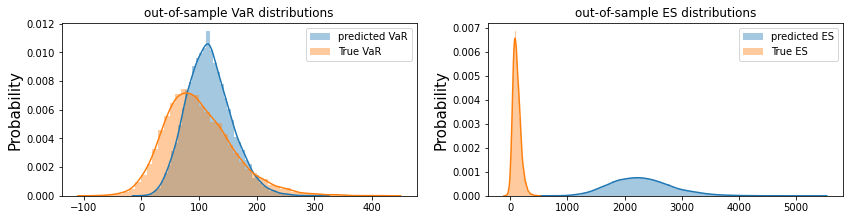

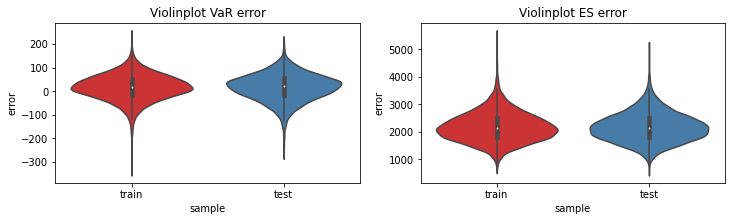

In [69]:
plot_function(var_NN(X_train), true_VaR_train,
              es_NN(X_train), true_ES_train,
              var_NN(X_test), true_VaR_test,
              es_NN(X_test), true_ES_test)

### Random projection as randomized layer 

In [71]:
p1 = time.time()

RP_dim = 100
RP_var = Randomprojection(Layers=[dim_X, RP_dim], random_state= None, activation= 'sigmoid')
RP_es = Randomprojection(Layers=[dim_X, RP_dim], random_state= None, activation= 'sigmoid')

var_NN = NN_nlayers(Layers=[RP_dim,1]).to(device)
es_NN = NN_nlayers(Layers=[RP_dim,1]).to(device)

joint_train_var_es_model(var_NN, es_NN, X_train_var = RP_var.fit_transform(X_train), 
                         X_train_es = RP_es.fit_transform(X_train),
                         y_train = Y_train, verbose = 50, epochs = 300)

print('\n Computation: ', time.time() - p1)

[iter 0] err = 3000.58
[iter 50] err = 186.364
[iter 100] err = 183.706
[iter 150] err = 183.513
[iter 200] err = 183.36
[iter 250] err = 183.201
[iter 300] err = 183.037

 Computation:  0.610543966293335


NRMSE in-sample VaR:  tensor(1.2835)
NRMSE in-sample ES:  tensor(1.5516)
NRMSE out-sample VaR:  tensor(1.2727)
NRMSE out-sample ES:  tensor(1.5504)


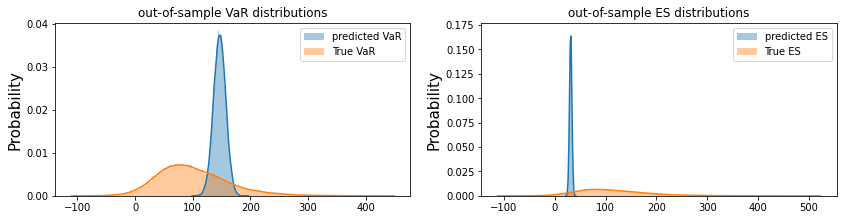

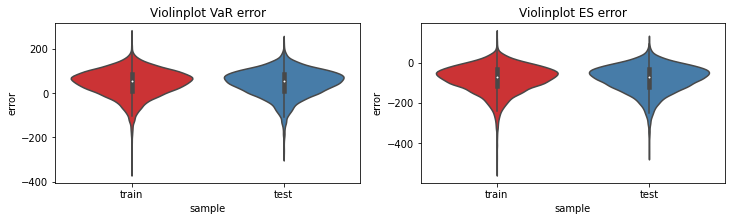

In [72]:
plot_function(var_NN(RP_var.fit_transform(X_train)), true_VaR_train,
              es_NN(RP_es.fit_transform(X_train)), true_ES_train,
              var_NN(RP_var.fit_transform(X_test)), true_VaR_test,
              es_NN(RP_es.fit_transform(X_test)), true_ES_test)

### Autoencoder as randomized layer and joint loss function

In [74]:
p1 = time.time()

Autoencoder_NN = Autoencoder(Layers=[dim_X, 50, 100], activation = 'relu').to(device)
train_quad_loss(Autoencoder_NN, X_train = X_train,
              y_train = X_train, verbose = None, epochs = 50)

var_NN = NN_nlayers(Layers=[100,1]).to(device)
es_NN = NN_nlayers(Layers=[100,1]).to(device)

joint_train_var_es_model(var_NN, es_NN, X_train_var = Autoencoder_NN.forward_central_layer(X_train).data, 
                         X_train_es = Autoencoder_NN.forward_central_layer(X_train).data,
                         y_train = Y_train, verbose = 50, epochs = 300)

print('\n Computation: ', time.time() - p1)

[iter 0] err = 5514.095
[iter 50] err = 734.707
[iter 100] err = 224.618
[iter 150] err = 223.026
[iter 200] err = 221.452
[iter 250] err = 219.949
[iter 300] err = 218.552

 Computation:  0.719853401184082


NRMSE in-sample VaR:  tensor(1.8122)
NRMSE in-sample ES:  tensor(25.6898)
NRMSE out-sample VaR:  tensor(1.8019)
NRMSE out-sample ES:  tensor(25.5940)


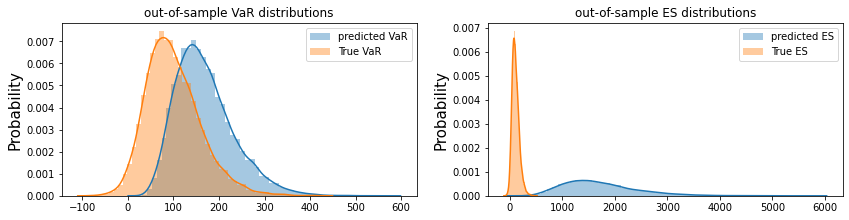

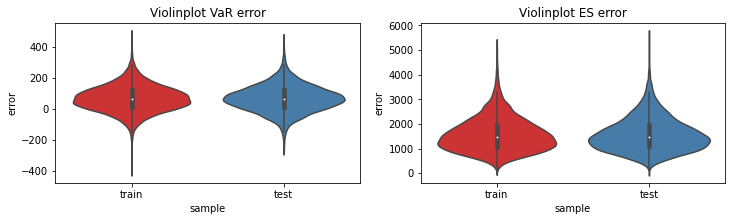

In [75]:
plot_function(var_NN(Autoencoder_NN.forward_central_layer(X_train).data), true_VaR_train,
              es_NN(Autoencoder_NN.forward_central_layer(X_train).data), true_ES_train,
              var_NN(Autoencoder_NN.forward_central_layer(X_test).data), true_VaR_test,
              es_NN(Autoencoder_NN.forward_central_layer(X_test).data), true_ES_test)

### RBF network

In [76]:
p1 = time.time()
RBF_hiddenlayer = RBFlayer(output_layer = 100, function ='Multiquadric', e = 2)
RBF_hiddenlayer.fit(X_train)

X_train_transformed = RBF_hiddenlayer.transform(X_train).data
X_test_transformed = RBF_hiddenlayer.transform(X_test).data

var_NN = NN_nlayers(Layers=[100,1]).to(device)
es_NN = NN_nlayers(Layers=[100,1]).to(device)

joint_train_var_es_model(var_NN, es_NN, X_train_var = X_train_transformed, 
                         X_train_es = X_train_transformed,
                         y_train = Y_train, verbose = 50, epochs = 500)

print('\n Computation: ', time.time() - p1)

[iter 0] err = 3238.825
[iter 50] err = 250.768
[iter 100] err = 176.034
[iter 150] err = 175.489
[iter 200] err = 175.47
[iter 250] err = 175.451
[iter 300] err = 175.43
[iter 350] err = 175.408
[iter 400] err = 175.384
[iter 450] err = 175.359
[iter 500] err = 175.334

 Computation:  2.173722743988037


NRMSE in-sample VaR:  tensor(1.2380)
NRMSE in-sample ES:  tensor(7.9606)
NRMSE out-sample VaR:  tensor(1.2315)
NRMSE out-sample ES:  tensor(7.9164)


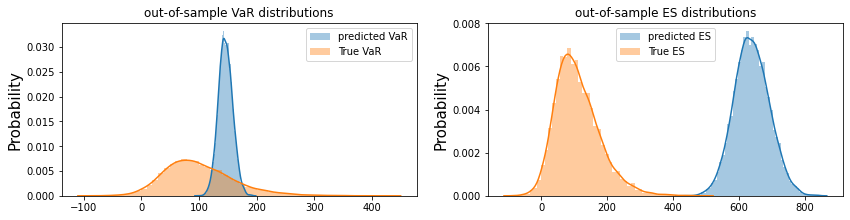

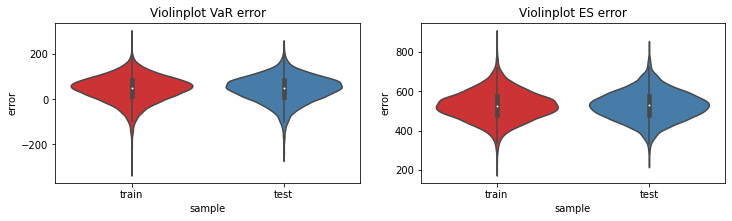

In [77]:
plot_function(var_NN(X_train_transformed), true_VaR_train,
              es_NN(X_train_transformed), true_ES_train,
              var_NN(X_test_transformed), true_VaR_test,
              es_NN(X_test_transformed), true_ES_test)

## 5.3 Multi-obj approach

In [0]:
def l2_norm2(x):
    return torch.sum(torch.pow(x,2))

In [0]:
def multi_train_var_es_model(model_var, model_es, X_train_var, X_train_es, y_train, 
                             eps = 0.025, g1_func = g1, g2_func = g2, g2_dot_func = g2_dot,
                             epochs=300, stop_eps = 1e-8, verbose = None) :
    t = torch.tensor(np.random.uniform(size = 1), requires_grad = True)
    zero_vector = torch.zeros_like(Y_train).to(device)

    i = 0
    err = np.inf
    
    optimizer = torch.optim.Adam( list(model_var.parameters()) + list(model_es.parameters()) , lr=0.1)
    optimizer_t = torch.optim.Adam(t, lr=.01)
    if verbose != None : 
        print('Initial t = {}'.format(round(t.detach().numpy()[0],3)))
    while (abs(err) > stop_eps) and (i < epochs):
        optimizer.zero_grad()
        optimizer_t.zero_grad()

        q = model_var.forward(X_train_var)
        e = model_es.forward(X_train_es)
        q_t = model_var.forward(X_train_var).data
        e_t = model_es.forward(X_train_es).data
        
        loss = ( t * torch.mean(1/eps*torch.max(g1_func(y_train) - g1_func(q), zero_vector) + g1_func(q)) + 
          (1-t) * torch.mean(g2_func(e) - g2_dot_func(e)*(e - q - 1/eps*torch.max(y_train - q, zero_vector))) )
        loss.backward()
        optimizer.step()
        err = loss.data.item()
        if verbose != None : 
            if i % verbose == 0:
                print('[iter {}] err = {}, t={}'.format(i, round(err, 3), round(t.detach().numpy()[0],3)))

        i += 1

        q_t.requires_grad=True
        e_t.requires_grad=True

        loss_var_t = torch.mean(1/eps*torch.max(g1_func(y_train) - g1_func(q_t), zero_vector) + g1_func(q_t))
        loss_es_t = torch.mean(g2_func(e_t) - g2_dot_func(e_t)*(e_t - q_t - 1/eps*torch.max(y_train - q_t, zero_vector)) )

        loss_var_t.backward()
        grad_qt_loss_var = q_t.grad
        q_t.grad=None
        loss_es_t.backward()
        grad_qt_loss_es = q_t.grad
        grad_et_loss_es = e_t.grad

        loss_t = torch.sqrt(l2_norm2(t*grad_qt_loss_var + (1-t)*grad_qt_loss_es) + l2_norm2((1-t)*grad_et_loss_es))
        loss_t.backward()
        optimizer_t.step()
        with torch.no_grad():
            t = torch.clamp_(t, min = 0, max = 1)
    if verbose != None : 
        print('[iter {}] err = {}, t={}'.format(i, round(err, 3), round(t.detach().numpy()[0],3)))

### 1 hidden layer of 100 units networks without randomized layers (as slide)

In [0]:
p1 = time.time()

var_NN = NN_nlayers(Layers=[dim_X,100,1], activation = 'relu').to(device)
es_NN = NN_nlayers(Layers=[dim_X,100,1], activation = 'relu').to(device)

multi_train_var_es_model(model_var = var_NN, model_es = es_NN, 
                         X_train_var = X_train, X_train_es = X_train, 
                         y_train = Y_train, eps = 0.025,
                         epochs=300, stop_eps = 1e-8, verbose = 50)

print('\n Computation: ', time.time() - p1)

In [0]:
plot_function(var_NN(X_train), true_VaR_train,
              es_NN(X_train), true_ES_train,
              var_NN(X_test), true_VaR_test,
              es_NN(X_test), true_ES_test)

### 3 hidden layers networks without randomized layers (as XVA paper)

In [0]:
p1 = time.time()

var_NN = NN_nlayers(Layers=[dim_X,20,20,20,1])
es_NN = NN_nlayers(Layers=[dim_X,20,20,20,1])

multi_train_var_es_model(var_NN, es_NN, X_train_var = X_train, 
                         X_train_es = X_train,
                         y_train = Y_train, verbose = 50, epochs = 300)

print('\n Computation: ', time.time() - p1)

In [0]:
plot_function(var_NN(X_train), true_VaR_train,
              es_NN(X_train), true_ES_train,
              var_NN(X_test), true_VaR_test,
              es_NN(X_test), true_ES_test)

### Random projection as randomized layer 

In [0]:
p1 = time.time()

RP_dim = 100
RP_var = Randomprojection(Layers=[dim_X, RP_dim], random_state= None, activation= 'relu')
RP_es = Randomprojection(Layers=[dim_X, RP_dim], random_state= None, activation= 'relu')

var_NN = NN_nlayers(Layers=[RP_dim,1])
es_NN = NN_nlayers(Layers=[RP_dim,1])

multi_train_var_es_model(var_NN, es_NN, X_train_var = RP_var.fit_transform(X_train), 
                         X_train_es = RP_es.fit_transform(X_train),
                         y_train = Y_train, verbose = 50, epochs = 300)

print('\n Computation: ', time.time() - p1)

In [0]:
plot_function(var_NN(RP_var.fit_transform(X_train)), true_VaR_train,
              es_NN(RP_es.fit_transform(X_train)), true_ES_train,
              var_NN(RP_var.fit_transform(X_test)), true_VaR_test,
              es_NN(RP_es.fit_transform(X_test)), true_ES_test)

### Autoencoder as randomized layer

In [0]:
p1 = time.time()

Autoencoder_NN = Autoencoder(Layers=[dim_X, 50, 100], activation = 'relu')
train_pytorch(Autoencoder_NN, X_train = X_train,
              y_train = X_train, verbose = None, epochs = 200)

var_NN = NN_nlayers(Layers=[100,1])
es_NN = NN_nlayers(Layers=[100,1])

multi_train_var_es_model(var_NN, es_NN, X_train_var = Autoencoder_NN.forward_central_layer(X_train).data, 
                         X_train_es = Autoencoder_NN.forward_central_layer(X_train).data,
                         y_train = Y_train, verbose = 50, epochs = 200)

print('\n Computation: ', time.time() - p1)

In [0]:
plot_function(var_NN(Autoencoder_NN.forward_central_layer(X_train).data), true_VaR_train,
              es_NN(Autoencoder_NN.forward_central_layer(X_train).data), true_ES_train,
              var_NN(Autoencoder_NN.forward_central_layer(X_test).data), true_VaR_test,
              es_NN(Autoencoder_NN.forward_central_layer(X_test).data), true_ES_test)